In [1]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, TimeDistributed, Dropout

# **US GDP Forecasting in the Face of COVID-19: A Comparative Study of Advanced Machine Learning and Neural Network Techniques**

Welcome to this Jupyter Notebook, which contains the complete code for the 1970-2019 period, on forecasting US GDP using a variety of advanced machine learning and neural network techniques. For a more comprehensive analysis please refer to the Part I Notebook. This main Notebook, that includes the COVID-19 and post-COVID years, offers more detailed explanations and should be compared with this one.

This notebook is an integral part of our research paper titled "**US GDP Forecasting in the Face of COVID-19: A Comparative Study of Advanced Machine Learning and Neural Network Techniques**".

In [2]:
data = pd.read_csv('dataset.csv', delimiter=';')
for column in data.columns:
    if data[column].dtype == 'object':
        try:
            data[column] = data[column].str.replace(',', '.').astype(float)
        except ValueError:
            continue 
data.head(-1)

Date  US GDP (AR)  US unemployment  US 10-YEAR TREASURY BONDS YIELD  \
0    Q1 1970     5300.652      3644000.000                             7.37   
1    Q2 1970     5308.164      3869333.333                             7.71   
2    Q3 1970     5357.077      4346666.667                             7.46   
3    Q4 1970     5299.672      4512333.333                             6.85   
4    Q1 1971     5443.619      5359000.000                             6.02   
..       ...          ...              ...                              ...   
210  Q3 2022    21851.134      5990333.333                             3.11   
211  Q4 2022    21989.981      5494666.667                             3.83   
212  Q1 2023    22112.329      6295333.333                             3.65   
213  Q2 2023    22225.350      5732333.333                             3.59   
214  Q3 2023    22490.692      6348000.000                             4.15   

     US POPULATION      Non-Farm   US CPI  \
0           204246  1.392600e+07   38.100   
1           204941  1.365167e+07   38.633   
2           205664  1.345900e+07   39.033   
3           206352  1.291600e+07   39.600   
4           206960  1.302867e+07   39.933   
..             ...           ...      ...   
210         333925  9.044333e+06  295.509   
211         334326  9.095000e+06  298.441   
212         334664  9.105333e+06  301.203   
213         335080  9.096667e+06  303.467   
214         335612  9.075333e+06  306.034   

     US NOMINAL BROAD EFFECTIVE EXCH.RATE  US PERSONAL CURRENT TAXES (AR)  \
0                                35.86958                         104.573   
1                                35.84668                         105.512   
2                                35.60398                         100.657   
3                                35.61470                         101.538   
4                                35.48114                          98.331   
..                                    ...                             ...   
210                             131.40834                        3137.041   
211                             133.23639                        3095.669   
212                             128.20826                        2763.673   
213                             128.29949                        2703.839   
214                             129.82510                        2765.325   

     US GOVERNMENT CONSUMPTION & INVESTMENT (AR)  US CURRENT ACCOUNT BALANCE  
0                                        247.889                         620  
1                                        249.143                         972  
2                                        254.584                         515  
3                                        258.708                         222  
4                                        261.905                         683  
..                                           ...                         ...  
210                                     4477.855                     -222757  
211                                     4572.408                     -216154  
212                                     4643.890                     -212655  
213                                     4669.808                     -214980  
214                                     4794.830                     -196378  

[215 rows x 11 columns]

<Figure size 1000x500 with 0 Axes>

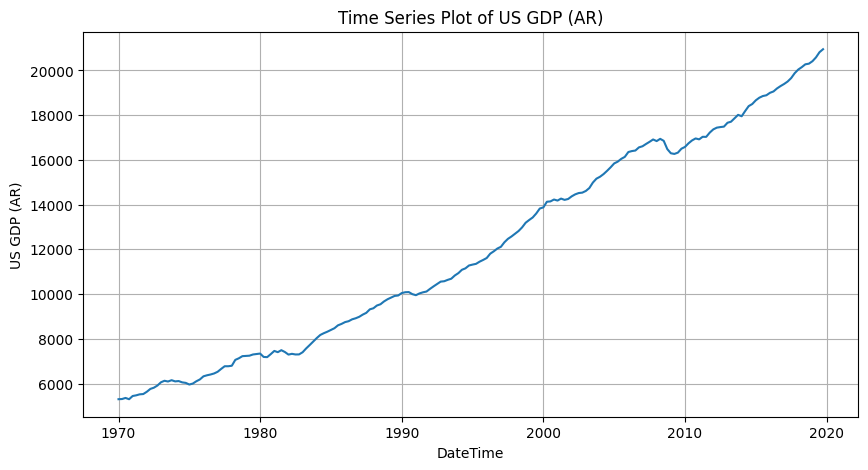

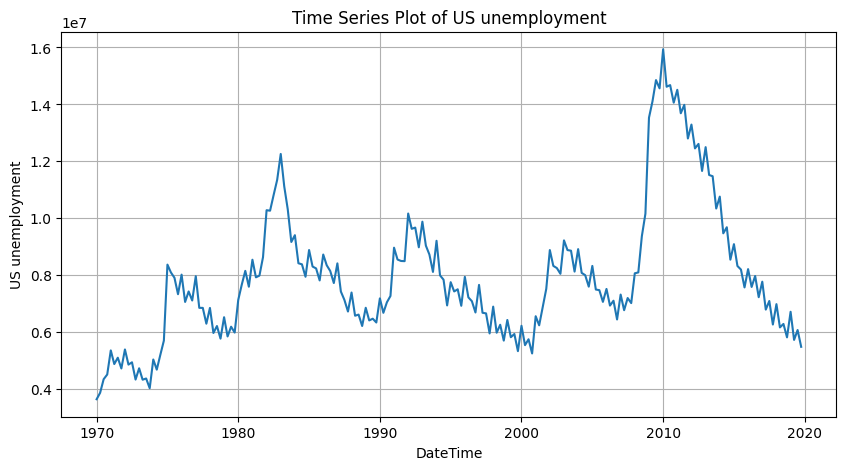

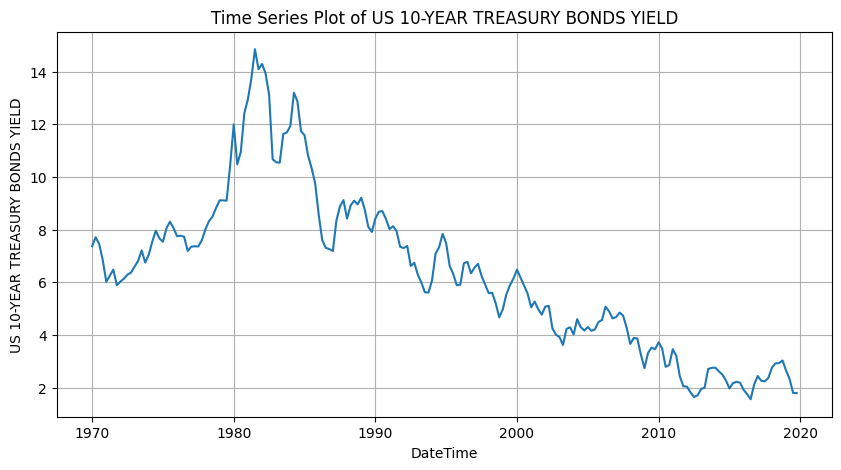

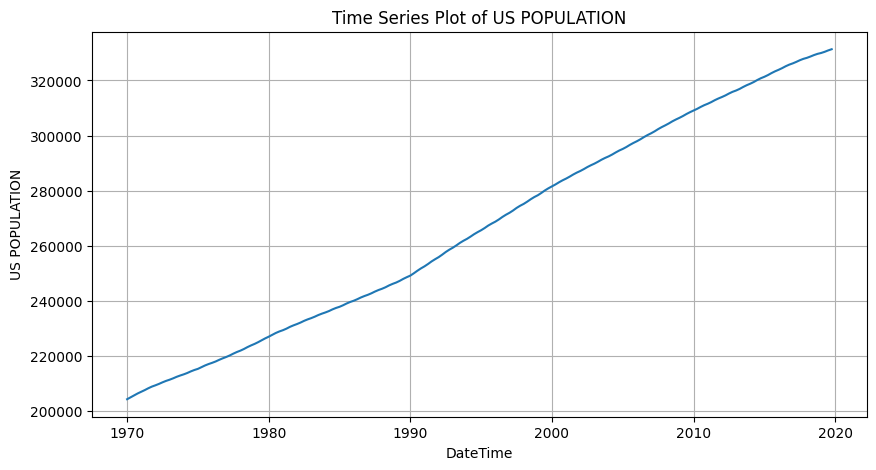

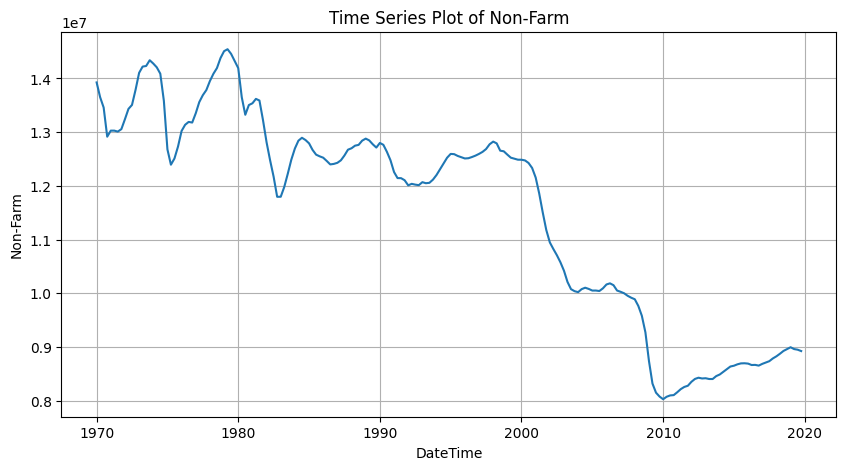

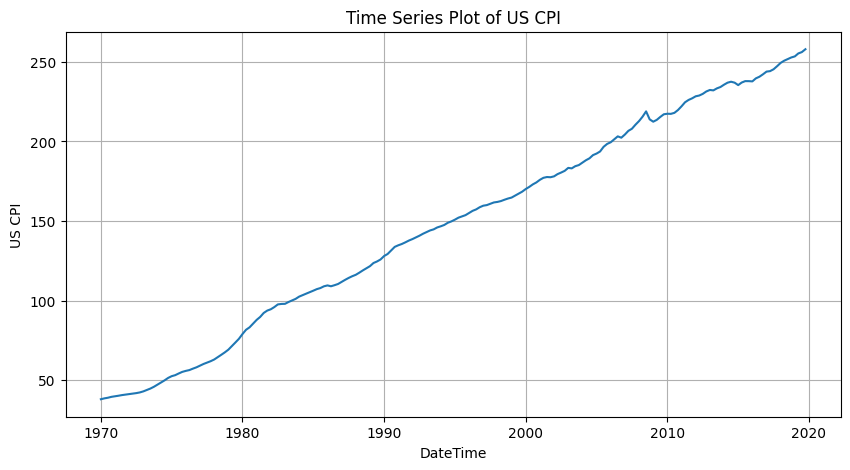

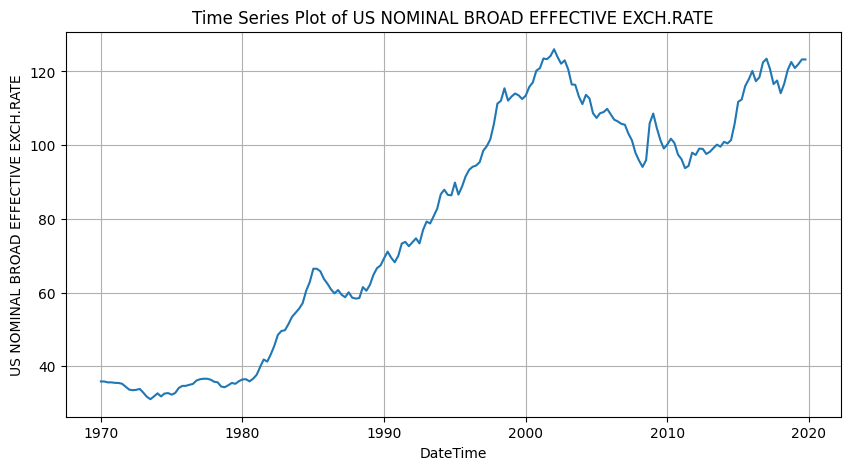

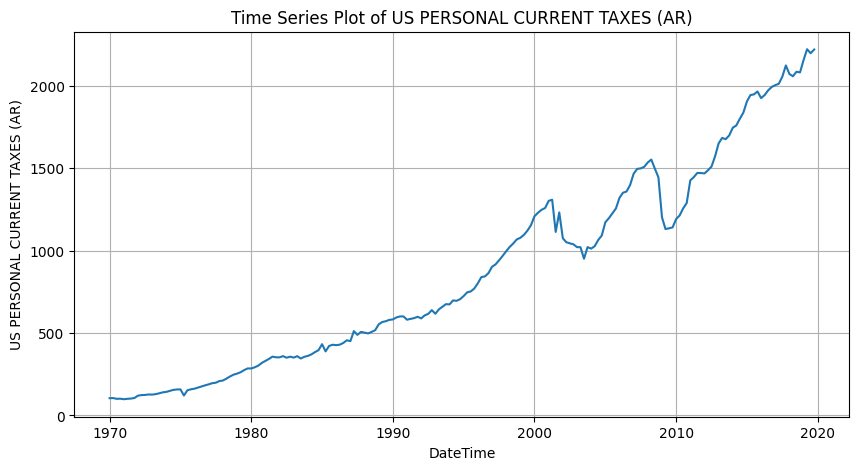

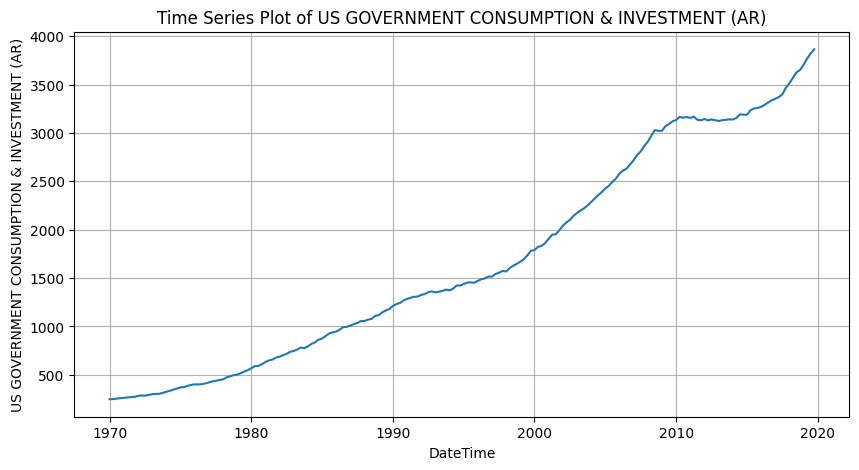

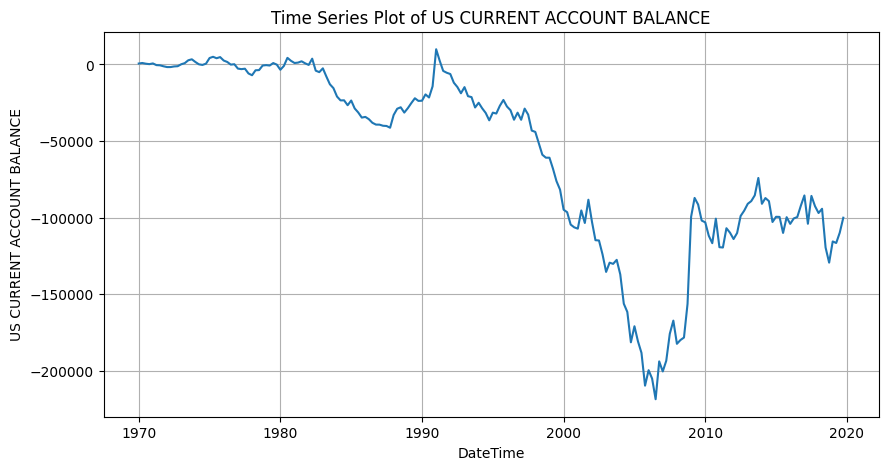

In [3]:
def parse_quarter(string):
    q, year = string.split(' ')
    year = int(year)
    quarter = int(q[1])
    month = 3 * quarter - 2  
    return pd.Timestamp(year=year, month=month, day=1)
data['DateTime'] = data['Date'].apply(parse_quarter)
data.set_index('DateTime', inplace=True)

data = data[data.index.year < 2020]

for column in data.columns:  
    plt.figure(figsize=(10, 5))  
    if column != 'Date': 
        plt.plot(data.index, data[column])
        plt.title(f'Time Series Plot of {column}')
        plt.xlabel('DateTime')
        plt.ylabel(column)
        plt.grid(True)
        plt.show()

In [4]:
data.head(-1)

Date  US GDP (AR)  US unemployment  \
DateTime                                            
1970-01-01  Q1 1970     5300.652      3644000.000   
1970-04-01  Q2 1970     5308.164      3869333.333   
1970-07-01  Q3 1970     5357.077      4346666.667   
1970-10-01  Q4 1970     5299.672      4512333.333   
1971-01-01  Q1 1971     5443.619      5359000.000   
...             ...          ...              ...   
2018-07-01  Q3 2018    20276.154      6288666.667   
2018-10-01  Q4 2018    20304.874      5816666.667   
2019-01-01  Q1 2019    20415.150      6715666.667   
2019-04-01  Q2 2019    20584.528      5727333.333   
2019-07-01  Q3 2019    20817.581      6074666.667   

            US 10-YEAR TREASURY BONDS YIELD  US POPULATION      Non-Farm  \
DateTime                                                                   
1970-01-01                             7.37         204246  1.392600e+07   
1970-04-01                             7.71         204941  1.365167e+07   
1970-07-01                             7.46         205664  1.345900e+07   
1970-10-01                             6.85         206352  1.291600e+07   
1971-01-01                             6.02         206960  1.302867e+07   
...                                     ...            ...           ...   
2018-07-01                             2.93         329216  8.927667e+06   
2018-10-01                             3.03         329659  8.963333e+06   
2019-01-01                             2.65         329977  8.996667e+06   
2019-04-01                             2.33         330393  8.963000e+06   
2019-07-01                             1.80         330904  8.951333e+06   

             US CPI  US NOMINAL BROAD EFFECTIVE EXCH.RATE  \
DateTime                                                    
1970-01-01   38.100                              35.86958   
1970-04-01   38.633                              35.84668   
1970-07-01   39.033                              35.60398   
1970-10-01   39.600                              35.61470   
1971-01-01   39.933                              35.48114   
...             ...                                   ...   
2018-07-01  251.686                             120.39311   
2018-10-01  252.711                             122.56123   
2019-01-01  253.386                             120.93336   
2019-04-01  255.247                             121.96557   
2019-07-01  256.089                             123.26284   

            US PERSONAL CURRENT TAXES (AR)  \
DateTime                                     
1970-01-01                         104.573   
1970-04-01                         105.512   
1970-07-01                         100.657   
1970-10-01                         101.538   
1971-01-01                          98.331   
...                                    ...   
2018-07-01                        2085.264   
2018-10-01                        2081.643   
2019-01-01                        2156.669   
2019-04-01                        2222.161   
2019-07-01                        2197.940   

            US GOVERNMENT CONSUMPTION & INVESTMENT (AR)  \
DateTime                                                  
1970-01-01                                      247.889   
1970-04-01                                      249.143   
1970-07-01                                      254.584   
1970-10-01                                      258.708   
1971-01-01                                      261.905   
...                                                 ...   
2018-07-01                                     3626.086   
2018-10-01                                     3650.847   
2019-01-01                                     3704.546   
2019-04-01                                     3768.165   
2019-07-01                                     3821.476   

            US CURRENT ACCOUNT BALANCE  
DateTime                                
1970-01-01                         620  
1970-04-01                         972  
1970-07-01 

## **Correlation for the new analysis**

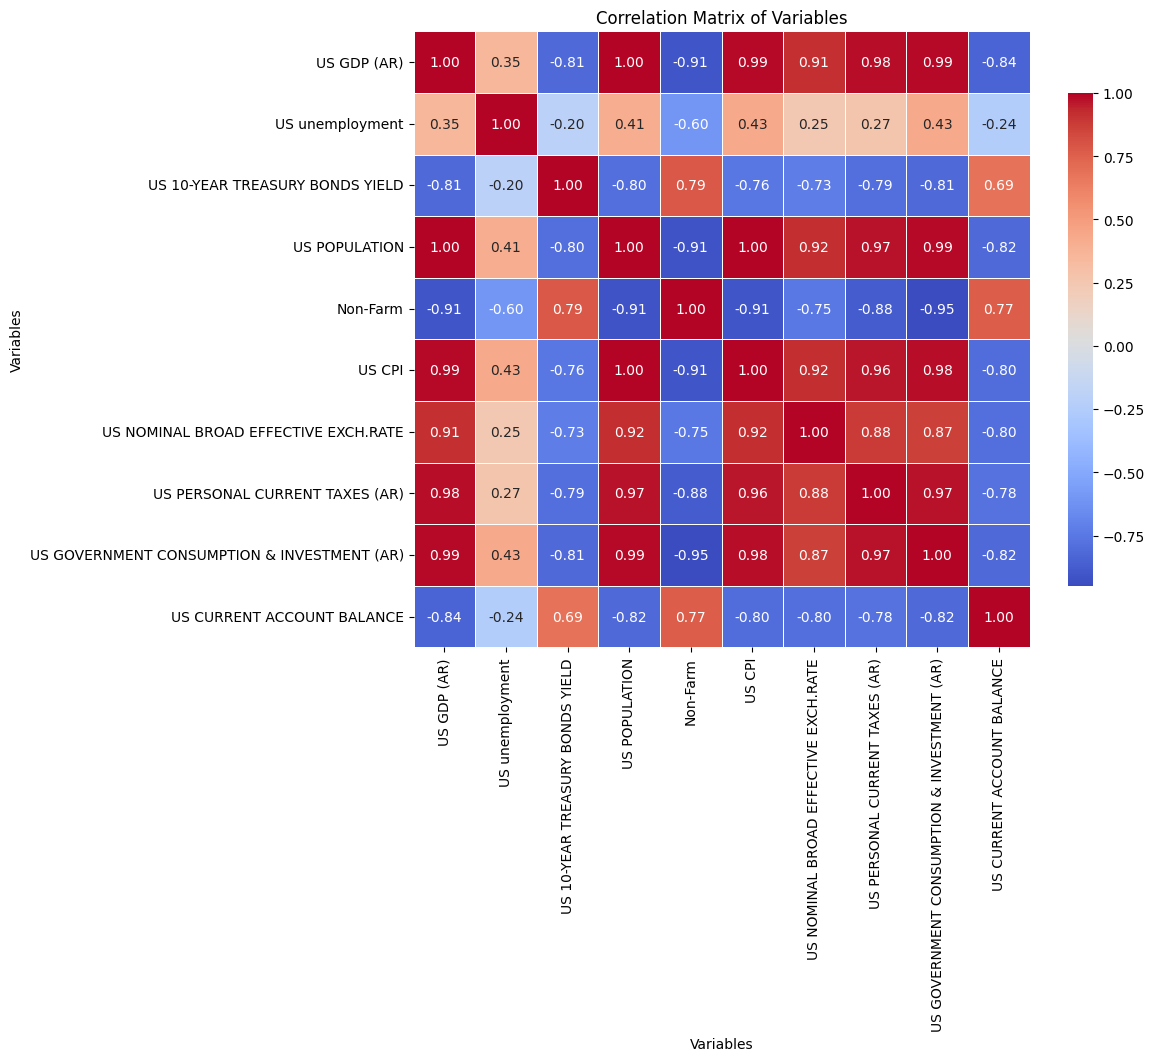

In [5]:
correlation_matr = data.drop('Date', axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matr, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

plt.title('Correlation Matrix of Variables')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.xticks(rotation=90)
plt.yticks(rotation=0)  

plt.show()

## **Stationarity Check**

The results for stationarity are consistent with our previous findings. 

In [6]:
def adf_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic': round(r[0], 4), 'pvalue': round(r[1], 4), 'critical_values': r[4]}
    p_value = r[1]
    def adjust(val, length=6): 
        return str(val).ljust(length)

    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {r[2]}')

    for key, val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(" => Series is Non-Stationary.")


for name, column in data.items():
    if pd.api.types.is_numeric_dtype(column):
        adf_test(column.dropna(), name=name)  
    else:
        print(f'Skipping non-numeric column: {name}')


Skipping non-numeric column: Date
    Augmented Dickey-Fuller Test on "US GDP (AR)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.6545
 No. Lags Chosen       = 2
 Critical value 1%     = -3.464
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.9980123148804614. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
    Augmented Dickey-Fuller Test on "US unemployment" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8671
 No. Lags Chosen       = 13
 Critical value 1%     = -3.466
 Critical value 5%     = -2.877
 Critical value 10%    = -2.575
 => P-Value = 0.04930592193639729. Rejecting Null Hypothesis.
 => Series is Stationary.
    Augmented Dickey-Fuller Test on "US 10-YEAR TREASURY BONDS YIELD" 
    ----

## **Differencing and new Stationarity Check** 

In [7]:
def adf_test(series, name=''):
    """Perform ADFuller to test for Stationarity of given series and print a formatted report"""
    result = adfuller(series.dropna(), autolag='AIC')  # Ensure there are no NaNs and instructs the function to use the Akaike Information Criterion (AIC) to select the optimal number of lags
    print(f'\nAugmented Dickey-Fuller Test on "{name}" after differencing')
    print('---------------------------------------------------------')
    print('Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f'Significance Level    = 0.05')
    print(f'Test Statistic        = {result[0]:.4f}')
    print(f'No. Lags Chosen       = {result[2]}')

    for key, value in result[4].items():
        print(f'Critical value {key} = {value:.3f}')

    print(f' => P-Value = {result[1]:.10f}.')
    if result[1] < 0.05:
        print(" => Rejecting Null Hypothesis.")
        print(" => Series is Stationary.")
    else:
        print(" => Weak evidence to reject the Null Hypothesis.")
        print(" => Series is Non-Stationary.")

for name, column in data.items():
    if pd.api.types.is_numeric_dtype(column):
        diff_column = column.diff().dropna()
        adf_test(diff_column, name=name)
    else:
        print(f'Skipping non-numeric column: {name}')


Skipping non-numeric column: Date

Augmented Dickey-Fuller Test on "US GDP (AR)" after differencing
---------------------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level    = 0.05
Test Statistic        = -6.5145
No. Lags Chosen       = 1
Critical value 1% = -3.464
Critical value 5% = -2.876
Critical value 10% = -2.575
 => P-Value = 0.0000000108.
 => Rejecting Null Hypothesis.
 => Series is Stationary.

Augmented Dickey-Fuller Test on "US unemployment" after differencing
---------------------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level    = 0.05
Test Statistic        = -3.9813
No. Lags Chosen       = 12
Critical value 1% = -3.466
Critical value 5% = -2.877
Critical value 10% = -2.575
 => P-Value = 0.0015113865.
 => Rejecting Null Hypothesis.
 => Series is Stationary.

Augmented Dickey-Fuller Test on "US 10-YEAR TREASURY BONDS YIELD" after differencing
-------------

### Result: 

Curisouly this time the Non-Stationary variables are : 

- US POPULATION

- US NOMINAL BROAD EFFECTIVE EXCH.RATE

- US GOVERNMENT CONSUMPTION & INVESTMENT (AR)

In [8]:
non_stationary_variables = ['US POPULATION', 'US GOVERNMENT CONSUMPTION & INVESTMENT (AR)','US NOMINAL BROAD EFFECTIVE EXCH.RATE']

data_diff = data.drop(non_stationary_variables, axis=1)  
data_diff = data_diff.apply(lambda x: x.diff().dropna() if pd.api.types.is_numeric_dtype(x) else x)

print(data_diff.head())  

data_diff.to_csv('processed_data2.csv', index=False)

               Date  US GDP (AR)  US unemployment  \
DateTime                                            
1970-01-01  Q1 1970          NaN              NaN   
1970-04-01  Q2 1970        7.512       225333.333   
1970-07-01  Q3 1970       48.913       477333.334   
1970-10-01  Q4 1970      -57.405       165666.666   
1971-01-01  Q1 1971      143.947       846666.667   

            US 10-YEAR TREASURY BONDS YIELD   Non-Farm  US CPI  \
DateTime                                                         
1970-01-01                              NaN        NaN     NaN   
1970-04-01                             0.34 -274333.33   0.533   
1970-07-01                            -0.25 -192666.67   0.400   
1970-10-01                            -0.61 -543000.00   0.567   
1971-01-01                            -0.83  112666.67   0.333   

            US PERSONAL CURRENT TAXES (AR)  US CURRENT ACCOUNT BALANCE  
DateTime                                                                
1970-01-01         

## **Correlation after using differentiation**

### The correlation matrix is significantly lower than the data with the covid 

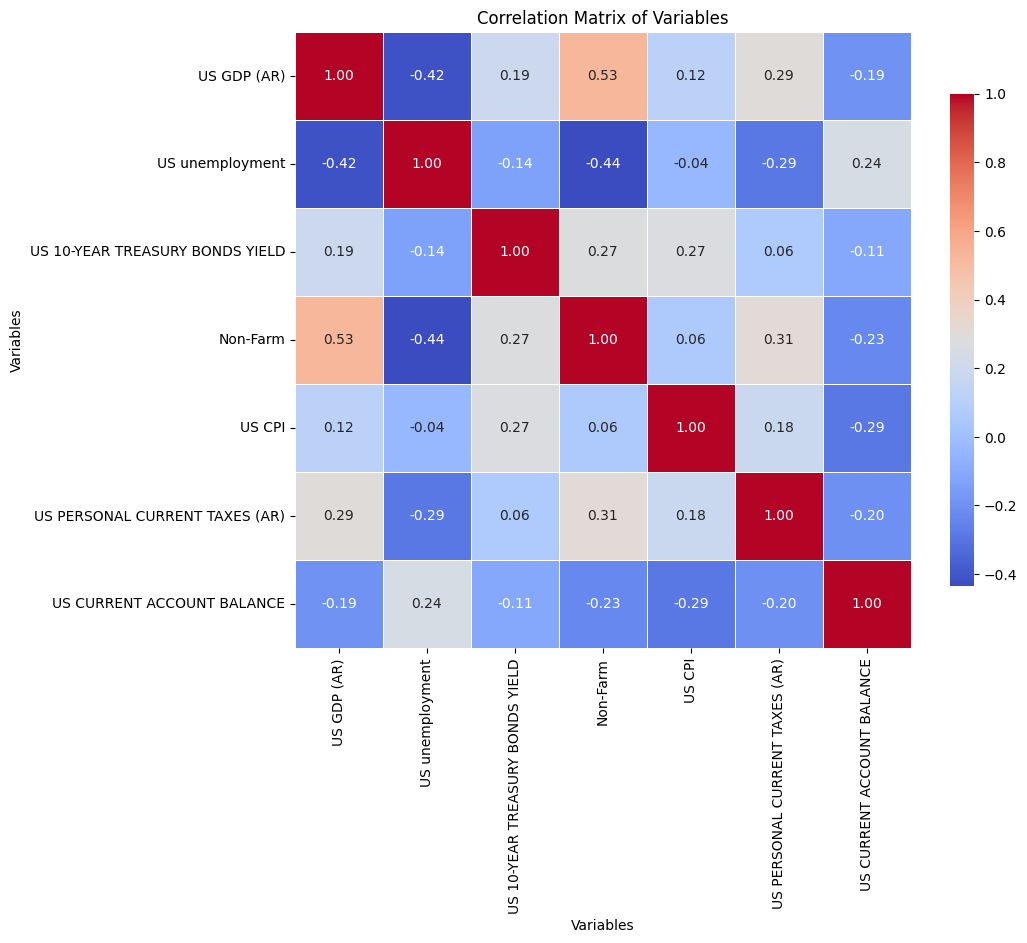

In [9]:
correlation_matrix = data_diff.drop('Date', axis=1).corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

plt.title('Correlation Matrix of Variables')
plt.xlabel('Variables')
plt.ylabel('Variables')


plt.xticks(rotation=90)
plt.yticks(rotation=0)  
plt.show()


## **Visual representation**

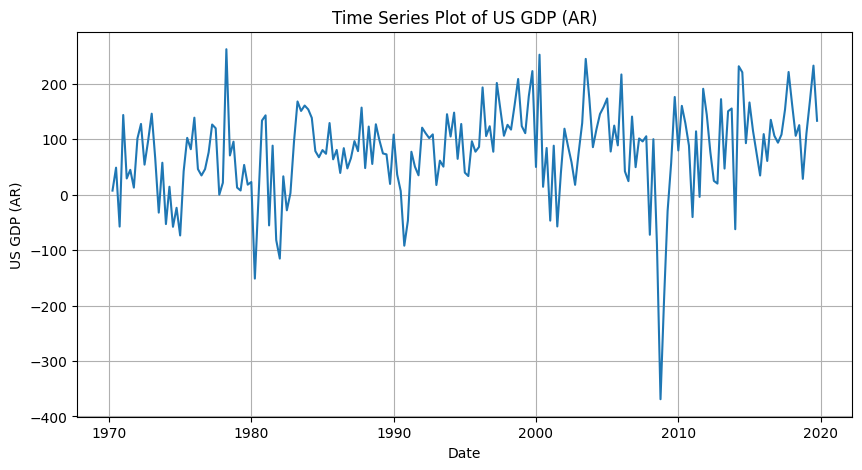

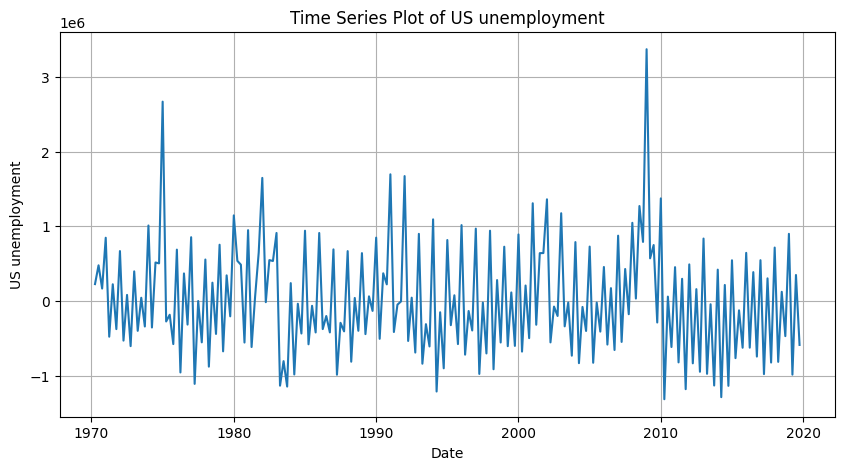

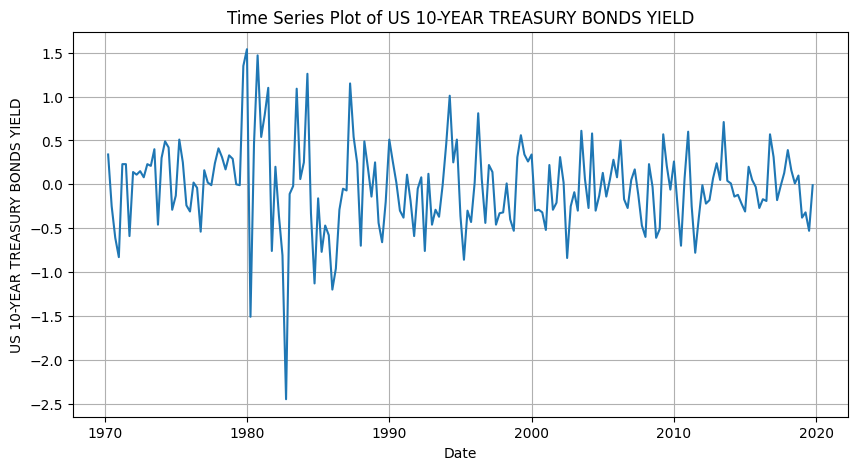

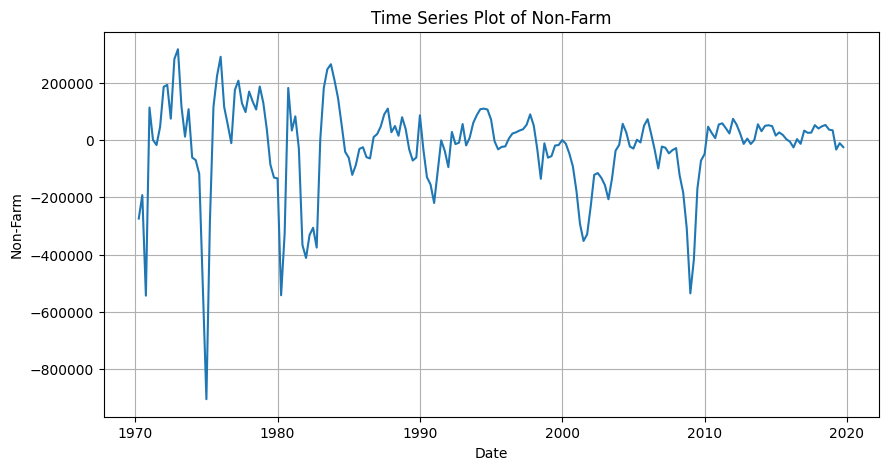

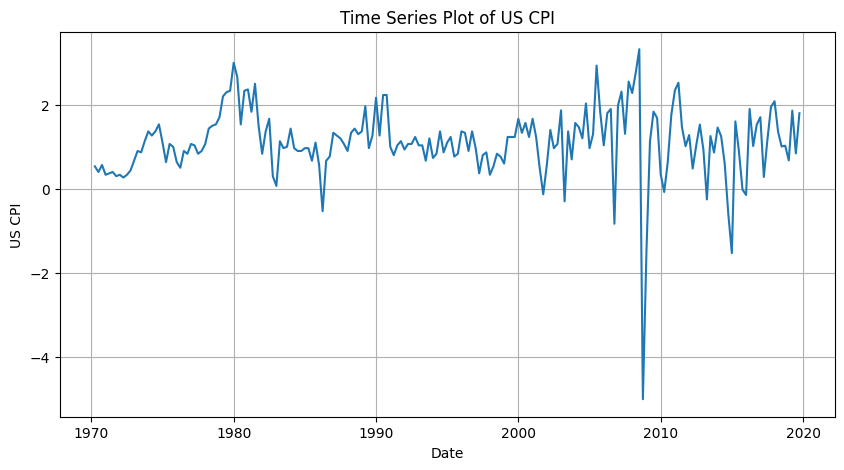

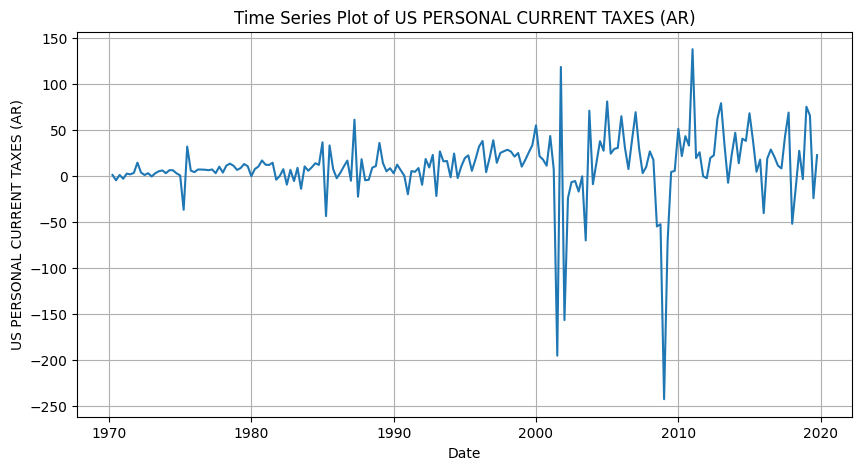

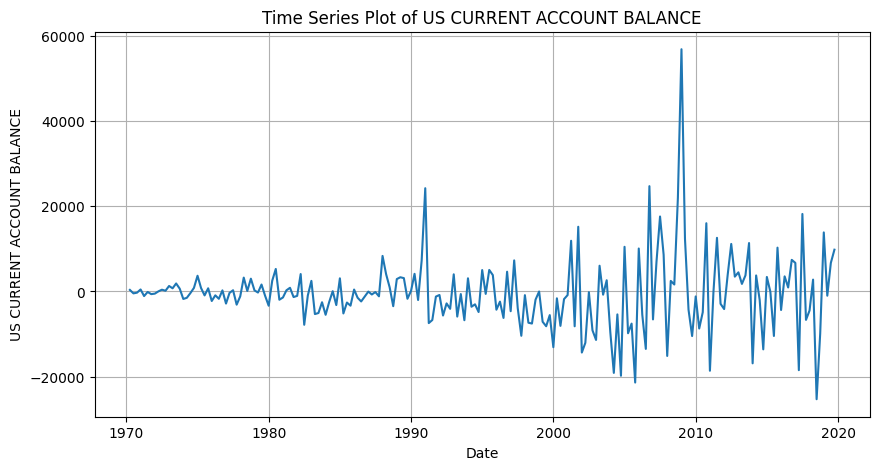

In [10]:
data_diff['Date'] = data_diff['Date'].apply(parse_quarter)
# Set 'Date' as the index of the dataframe
data_diff.set_index('Date', inplace=True)

# Plot each column
for column in data_diff.columns:
    plt.figure(figsize=(10, 5))  # Set the figure size for better readability
    plt.plot(data_diff.index, data_diff[column])  # Use data_diff for both index and column
    plt.title(f'Time Series Plot of {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()

## **Models and evaluation**

## Comparison of US GDP Data With and Without COVID Years

In [11]:
data_diff = data_diff.dropna()
mean_gdp = data_diff['US GDP (AR)'].mean()

gdp_stats = data_diff['US GDP (AR)'].describe()
baseline_mse = ((data_diff['US GDP (AR)'] - mean_gdp) ** 2).mean()
baseline_mae = abs(data_diff['US GDP (AR)'] - mean_gdp).mean()

print("GDP Statistics:\n", gdp_stats)
print("Baseline MSE:", baseline_mse)
print("Baseline MAE:", baseline_mae)

GDP Statistics:
 count    199.000000
mean      78.645407
std       82.587320
min     -368.945000
25%       37.763500
50%       85.920000
75%      127.788500
max      262.660000
Name: US GDP (AR), dtype: float64
Baseline MSE: 6786.390717658448
Baseline MAE: 60.52223155980916


**Observations Count**:

- Including COVID years: 215
- Excluding COVID years: 199

**Mean**:

- Including COVID years: 80.830712
- Excluding COVID years: 78.645407

    The mean GDP is slightly higher when including the COVID years, suggesting an overall slight increase in the average GDP despite the disruptions caused by the pandemic.

**Standard Deviation**:

- Including COVID years: 176.489584
- Excluding COVID years: 82.587320

    The standard deviation is significantly higher when including the COVID years, indicating increased volatility and larger fluctuations in GDP during and after the pandemic.

**Minimum and Maximum**:

- Minimum GDP:
            Including COVID years: -1630.723000
            Excluding COVID years: -368.945000
- Maximum GDP:
            Including COVID years: 1476.955000
            Excluding COVID years: 262.660000

    The minimum and maximum GDP values show more extreme fluctuations during the COVID years, reflecting the economic turmoil and recovery phases.

**Baseline Metrics**:

- Baseline MSE:
            Including COVID years: 31003.696154679583
            Excluding COVID years: 6786.390717654848

     The Baseline MSE is much higher when including the COVID years, indicating greater errors and deviations from the mean GDP prediction during this period.

- Baseline MAE:
            Including COVID years: 80.04679489453765
            Excluding COVID years: 60.52223155980916

     Similarly, the Baseline MAE is higher for the data including the COVID years, further confirming increased prediction errors and economic volatility.

**Conclusion**

The inclusion of COVID years (2020-2024) in the data results in higher volatility and fluctuations in the US GDP. The exclusion of these years shows a more stable economic period with lower variability and prediction errors.

## **VIF Results**

In [12]:
features = ['US unemployment', 'US 10-YEAR TREASURY BONDS YIELD', 'Non-Farm', 'US CPI',
            'US PERSONAL CURRENT TAXES (AR)','US CURRENT ACCOUNT BALANCE']

X_original = data_diff[features]
poly = PolynomialFeatures(degree=1)
X_poly = poly.fit_transform(X_original)

if hasattr(poly, 'get_feature_names_out'):
    column_names = poly.get_feature_names_out(features)
else:
    column_names = poly.get_feature_names(features)

X_poly_df = pd.DataFrame(X_poly, columns=column_names)

X_poly_df = add_constant(X_poly_df)

vif_data_poly = pd.DataFrame()
vif_data_poly["Variable"] = X_poly_df.columns
vif_data_poly["VIF"] = [variance_inflation_factor(X_poly_df.values, i) for i in range(X_poly_df.shape[1])]

print(vif_data_poly)


                          Variable       VIF
0                                1  3.046310
1                  US unemployment  1.306651
2  US 10-YEAR TREASURY BONDS YIELD  1.168623
3                         Non-Farm  1.396334
4                           US CPI  1.204235
5   US PERSONAL CURRENT TAXES (AR)  1.188421
6       US CURRENT ACCOUNT BALANCE  1.188960


## OLS Multiple Linear Regression

                            OLS Regression Results                            
Dep. Variable:            US GDP (AR)   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     12.01
Date:                Tue, 21 May 2024   Prob (F-statistic):           5.08e-11
Time:                        10:23:50   Log-Likelihood:                -896.66
No. Observations:                 159   AIC:                             1807.
Df Residuals:                     152   BIC:                             1829.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

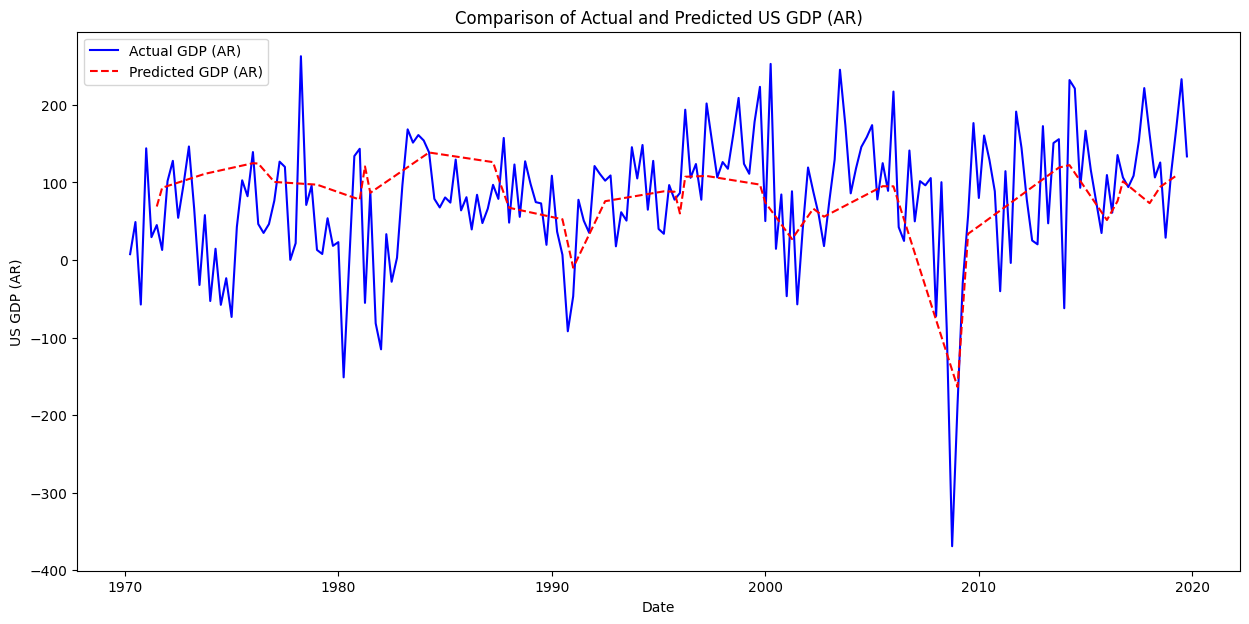

In [13]:
data_diff.sort_index(inplace=True) 

X = data_diff[['US unemployment', 'US 10-YEAR TREASURY BONDS YIELD', 'Non-Farm', 'US CPI',
               'US PERSONAL CURRENT TAXES (AR)', 'US CURRENT ACCOUNT BALANCE']]
y = data_diff['US GDP (AR)']

X = sm.add_constant(X) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Sort the test data by index, creating a copy to avoid SettingWithCopyWarning
X_test = X_test.sort_index().copy()  
y_test = y_test.loc[X_test.index]  

model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())
y_pred_test = results.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

print("Mean Squared Error (MSE) on Test Set: {:.2f}".format(mse))
print("Mean Absolute Error (MAE) on Test Set: {:.2f}".format(mae))


plt.figure(figsize=(15, 7))
plt.plot(data_diff.index, y, label='Actual GDP (AR)', color='blue') 
plt.plot(X_test.index, y_pred_test, label='Predicted GDP (AR)', linestyle='--', color='red')  
plt.title('Comparison of Actual and Predicted US GDP (AR)')
plt.xlabel('Date')
plt.ylabel('US GDP (AR)')
plt.legend()
plt.show()


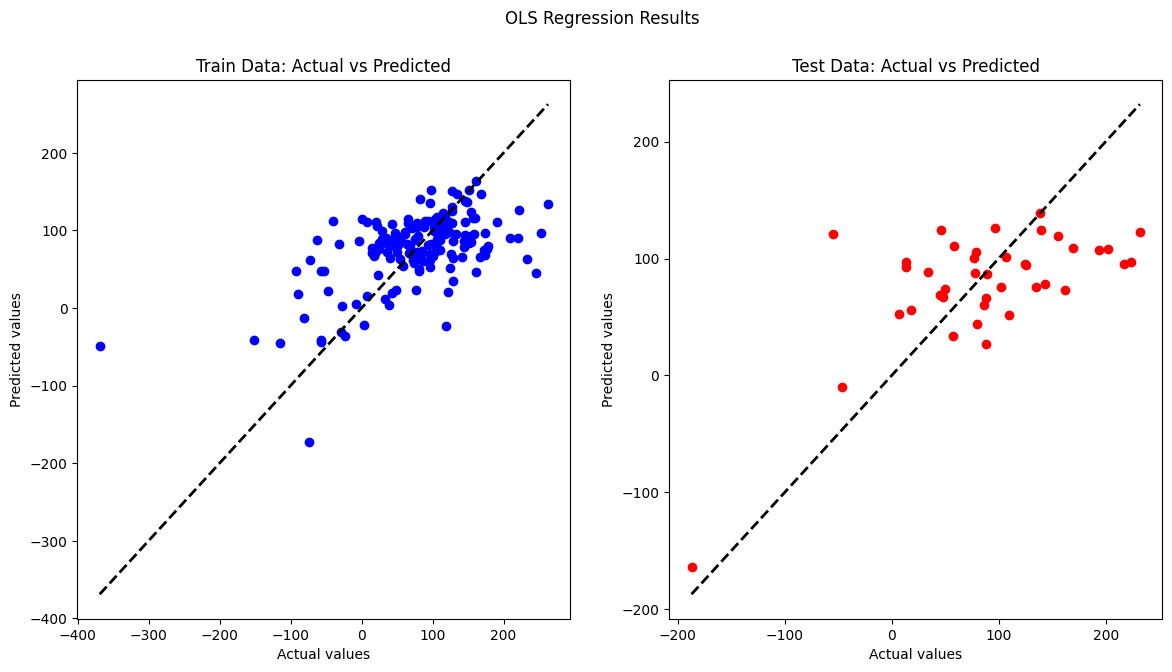

In [14]:
y_test_pred = results.predict(X_test)
y_train_pred = results.predict(X_train)

# Training data plot
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(y_train, y_train_pred, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)  # Line for perfect prediction
plt.title('Train Data: Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

# Testing data plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.scatter(y_test, y_test_pred, color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line for perfect prediction
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.suptitle('OLS Regression Results')
plt.show()


## Linear Regression with Cross-Validation without Time Series

If we isolate the best output of the code, it is possible to see that this regression fits the data pretty well, and better than the data containing the pandemic. 

R^2 for each split : [-0.2676712378994539, 0.5413100824958959, 0.09362528466264164, 0.175701612707573, -0.2368511906373425]
R^2 adjusted for each split: [-0.49815691751753644, 0.4579119156769679, -0.07117011812596896, 0.025829178654404483, -0.46876078888184414]
Mean Squared Error: [5543.089196741785, 2474.941483600653, 3811.492809589614, 10469.58616709395, 5966.421468486149]
Mean Absolute Error: [63.88157241744277, 34.30817548716969, 49.405030445301314, 66.94079362957692, 61.31999215781605]
Average Mean Squared Error: 5653.11
Average Mean Absolute Error: 55.17


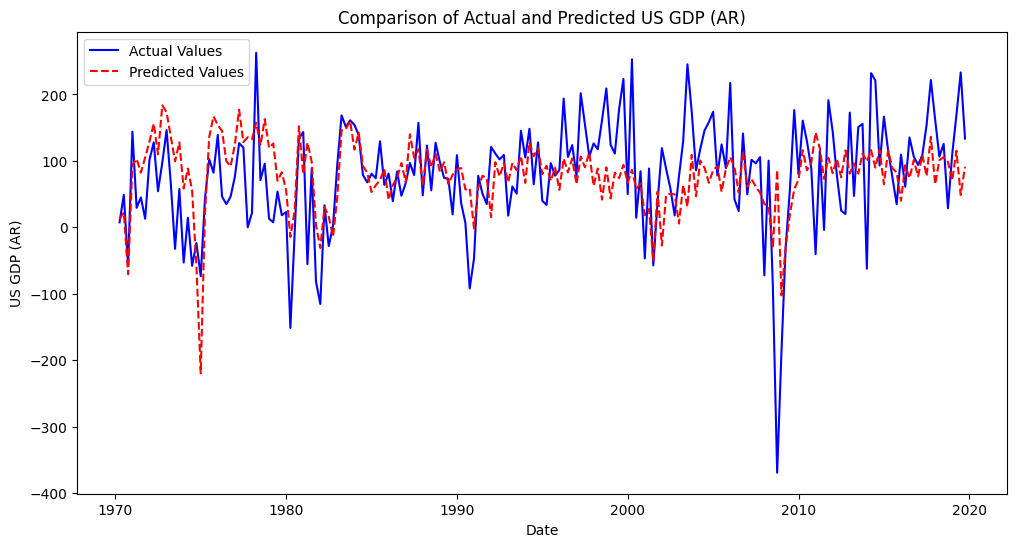

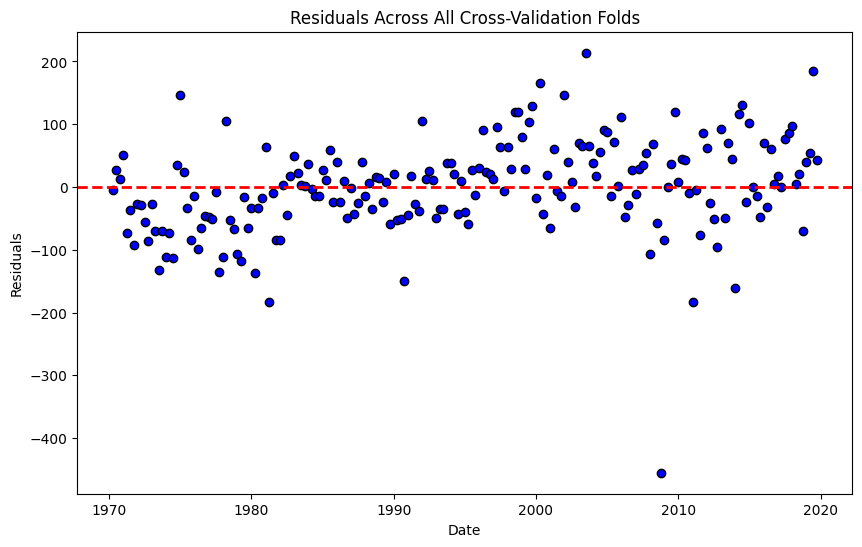

In [15]:
X = data_diff[['US unemployment', 'US 10-YEAR TREASURY BONDS YIELD', 'Non-Farm', 'US CPI',
               'US PERSONAL CURRENT TAXES (AR)', 
               'US CURRENT ACCOUNT BALANCE']]
y = data_diff['US GDP (AR)']
X = sm.add_constant(X)  

model = LinearRegression()
kf = KFold(n_splits=5)

# Lists to store metrics
mse_scores = []
mae_scores = []
residuals_list = []
r_squared = []
adjusted_r_squared = []
predicted_values = []
actual_values = []
dates_for_plot = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dates_test = X_test.index

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predicted_values.extend(y_pred)
    actual_values.extend(y_test)
    dates_for_plot.extend(dates_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse_scores.append(mse)
    mae_scores.append(mae)

    
    residuals = y_test - y_pred
    residuals_list.extend(residuals)

    
    SS_res = np.sum(residuals**2)
    SS_tot = np.sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (SS_res / SS_tot)
    n = len(y_test) 
    p = X_train.shape[1] - 1  # number of predictors; adjust for constant
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    r_squared.append(r2)
    adjusted_r_squared.append(adj_r2)
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)

print("R^2 for each split :", r_squared)
print("R^2 adjusted for each split:", adjusted_r_squared)
print("Mean Squared Error:", (mse_scores))
print("Mean Absolute Error:", (mae_scores))
print(f"Average Mean Squared Error: {avg_mse:.2f}")
print(f"Average Mean Absolute Error: {avg_mae:.2f}")
# Plotting the comparison of Actual and Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(dates_for_plot, actual_values, label='Actual Values', color='blue')
plt.plot(dates_for_plot, predicted_values, label='Predicted Values', linestyle='--', color='red')
plt.title('Comparison of Actual and Predicted US GDP (AR)')
plt.xlabel('Date')
plt.ylabel('US GDP (AR)')
plt.legend()
plt.show()

# Plotting Residuals
plt.figure(figsize=(10, 6))
plt.scatter(dates_for_plot, residuals_list, color='blue', edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Across All Cross-Validation Folds')
plt.show()


## Linear Regression with Cross-Validation with Time Series

R^2 for each split : [-0.47479335863487715, 0.34090601427190736, -0.2487979879048945, 0.11330819922174551, -0.31055937597527805]
R^2 adjusted for each split: [-0.8151302875506181, 0.18880740218080905, -0.5369821389598701, -0.0913129855732362, -0.612996155046496]
Mean Squared Error: [8970.592952914403, 1873.1705149906886, 6061.624620145561, 12438.304460608608, 5831.412313894809]
Mean Absolute Error: [77.42204149648124, 35.23000043035914, 63.40046355755834, 74.78645872474705, 62.842710244435814]
Average Mean Squared Error: 7035.02
Average Mean Absolute Error: 62.74


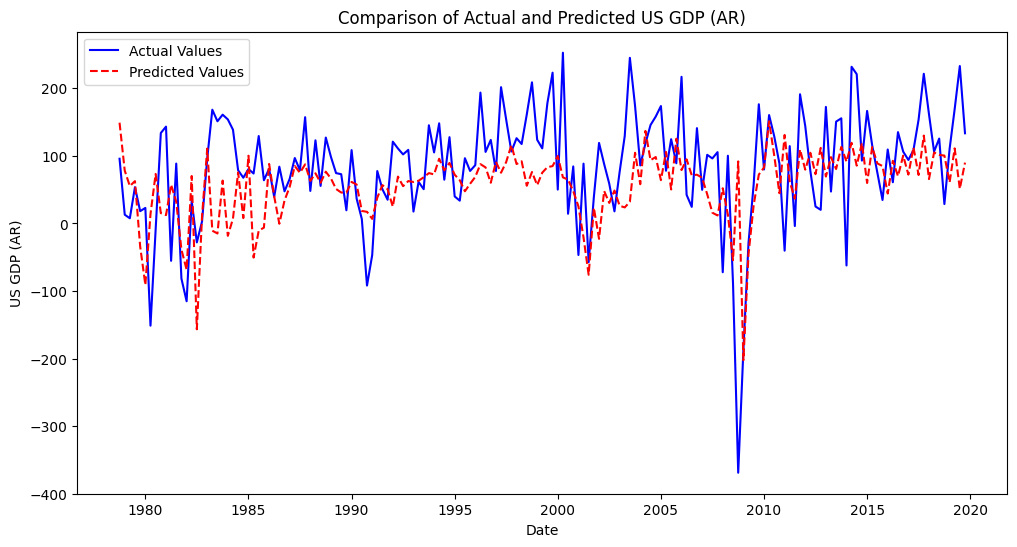

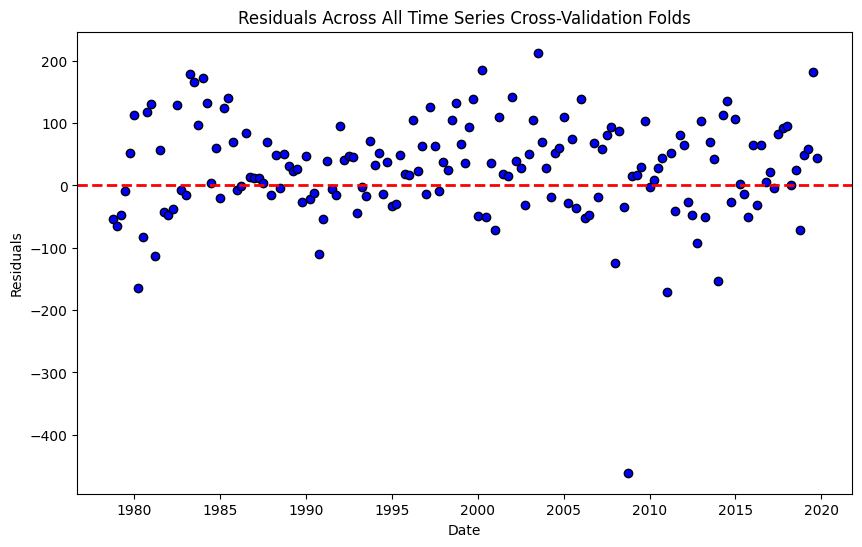

In [16]:
X = data_diff[['US unemployment', 'US 10-YEAR TREASURY BONDS YIELD', 'Non-Farm', 'US CPI',
               'US PERSONAL CURRENT TAXES (AR)', 
               'US CURRENT ACCOUNT BALANCE']]
y = data_diff['US GDP (AR)']
X = sm.add_constant(X) 
model = LinearRegression()

tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
mae_scores = []
residuals_list = []
r_squared = []
adjusted_r_squared = []
predicted_values = []
actual_values = []
dates_for_plot = []


for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dates_test = X_test.index

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predicted_values.extend(y_pred)
    actual_values.extend(y_test)
    dates_for_plot.extend(dates_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse_scores.append(mse)
    mae_scores.append(mae)

    
    residuals = y_test - y_pred
    residuals_list.extend(residuals)

    
    SS_res = np.sum(residuals**2)
    SS_tot = np.sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (SS_res / SS_tot)
    n = len(y_test)  # sample size
    p = X_train.shape[1] - 1  # number of predictors; adjust for constant
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    r_squared.append(r2)
    adjusted_r_squared.append(adj_r2)
    
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)
    
    
print("R^2 for each split :", r_squared)
print("R^2 adjusted for each split:", adjusted_r_squared)
print("Mean Squared Error:", (mse_scores))
print("Mean Absolute Error:", (mae_scores))
print(f"Average Mean Squared Error: {avg_mse:.2f}")
print(f"Average Mean Absolute Error: {avg_mae:.2f}")
# Plotting the comparison of Actual and Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(dates_for_plot, actual_values, label='Actual Values', color='blue')
plt.plot(dates_for_plot, predicted_values, label='Predicted Values', linestyle='--', color='red')
plt.title('Comparison of Actual and Predicted US GDP (AR)')
plt.xlabel('Date')
plt.ylabel('US GDP (AR)')
plt.legend()
plt.show()

# Plotting Residuals
plt.figure(figsize=(10, 6))
plt.scatter(dates_for_plot, residuals_list, color='blue', edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Across All Time Series Cross-Validation Folds')
plt.show()


## Ridge and Lasso Regression

Ridge Mean Squared Error: 5822.766559292849
Ridge Mean Absolute Error: 62.93631971151958
Ridge R-squared: -0.3086163175623131
Ridge Adjusted R-squared: -0.6750288864797609
Lasso Mean Squared Error: 5813.14303221782
Lasso Mean Absolute Error: 63.15477739157563
Lasso R-squared: -0.3064535132605013
Lasso Adjusted R-squared: -0.6722604969734416


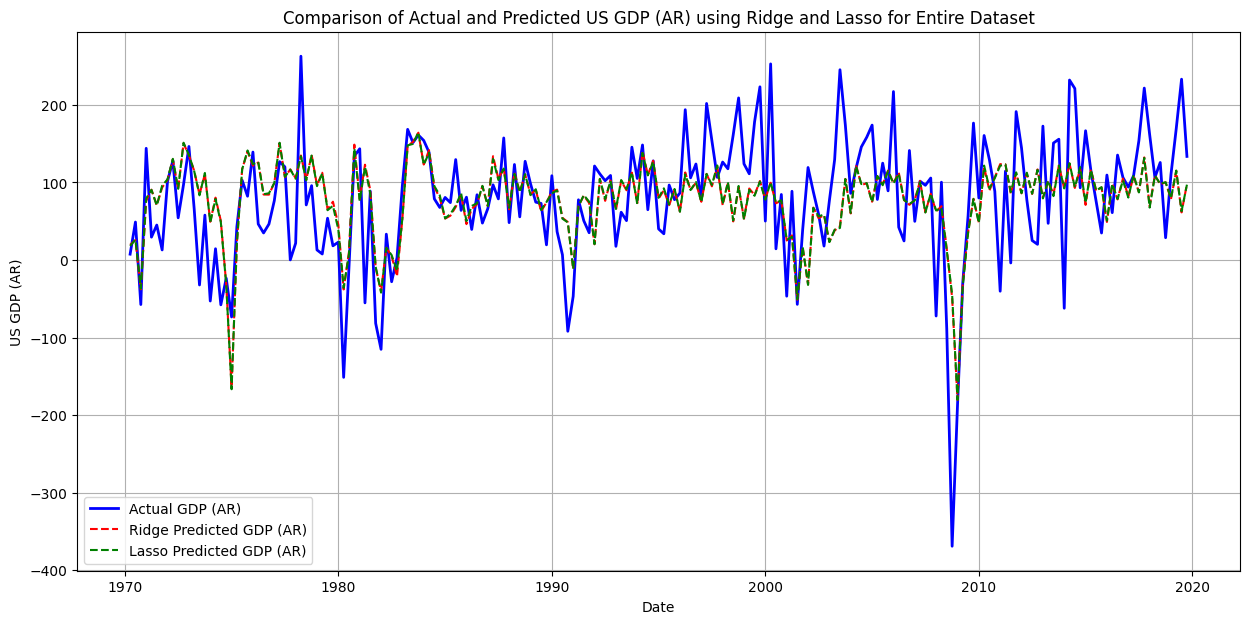

In [17]:
ridge_model = Ridge(alpha=10)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
r2_ridge = r2_score(y_test, y_pred_ridge)
adj_r2_ridge = 1 - (1-r2_ridge) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)


lasso_model = Lasso(alpha=1)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
r2_lasso = r2_score(y_test, y_pred_lasso)
adj_r2_lasso = 1 - (1-r2_lasso) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)


print("Ridge Mean Squared Error:", mean_squared_error(y_test, y_pred_ridge))
print("Ridge Mean Absolute Error:", mean_absolute_error(y_test, y_pred_ridge))
print("Ridge R-squared:", r2_ridge)
print("Ridge Adjusted R-squared:", adj_r2_ridge)
print("Lasso Mean Squared Error:", mean_squared_error(y_test, y_pred_lasso))
print("Lasso Mean Absolute Error:", mean_absolute_error(y_test, y_pred_lasso))
print("Lasso R-squared:", r2_lasso)
print("Lasso Adjusted R-squared:", adj_r2_lasso)


ridge_model.fit(X, y)
lasso_model.fit(X, y)

full_pred_ridge = ridge_model.predict(X)
full_pred_lasso = lasso_model.predict(X)


results_df = pd.DataFrame({
    'Actual GDP (AR)': y,
    'Ridge Predicted GDP (AR)': full_pred_ridge,
    'Lasso Predicted GDP (AR)': full_pred_lasso
}, index=y.index)  


plt.figure(figsize=(15, 7))
plt.plot(results_df['Actual GDP (AR)'], label='Actual GDP (AR)', color='blue', linewidth=2)
plt.plot(results_df['Ridge Predicted GDP (AR)'], label='Ridge Predicted GDP (AR)', linestyle='--', color='red')
plt.plot(results_df['Lasso Predicted GDP (AR)'], label='Lasso Predicted GDP (AR)', linestyle='--', color='green')
plt.title('Comparison of Actual and Predicted US GDP (AR) using Ridge and Lasso for Entire Dataset')
plt.xlabel('Date')
plt.ylabel('US GDP (AR)')
plt.legend()
plt.grid(True)
plt.show()


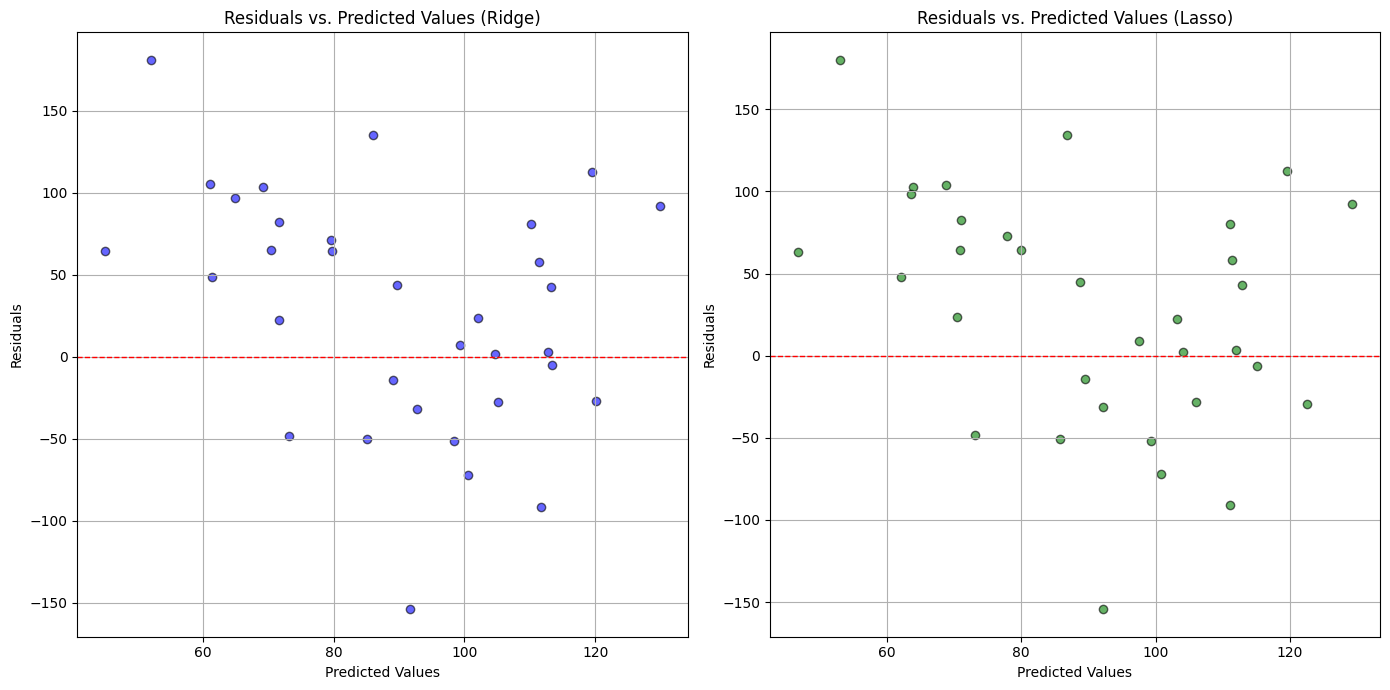

In [18]:
residuals_ridge = y_test - y_pred_ridge

residuals_lasso = y_test - y_pred_lasso

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(y_pred_ridge, residuals_ridge, color='blue', edgecolor='k', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs. Predicted Values (Ridge)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)

plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.scatter(y_pred_lasso, residuals_lasso, color='green', edgecolor='k', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs. Predicted Values (Lasso)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()


## Ridge and Lasso Cross-Validation without Time Series

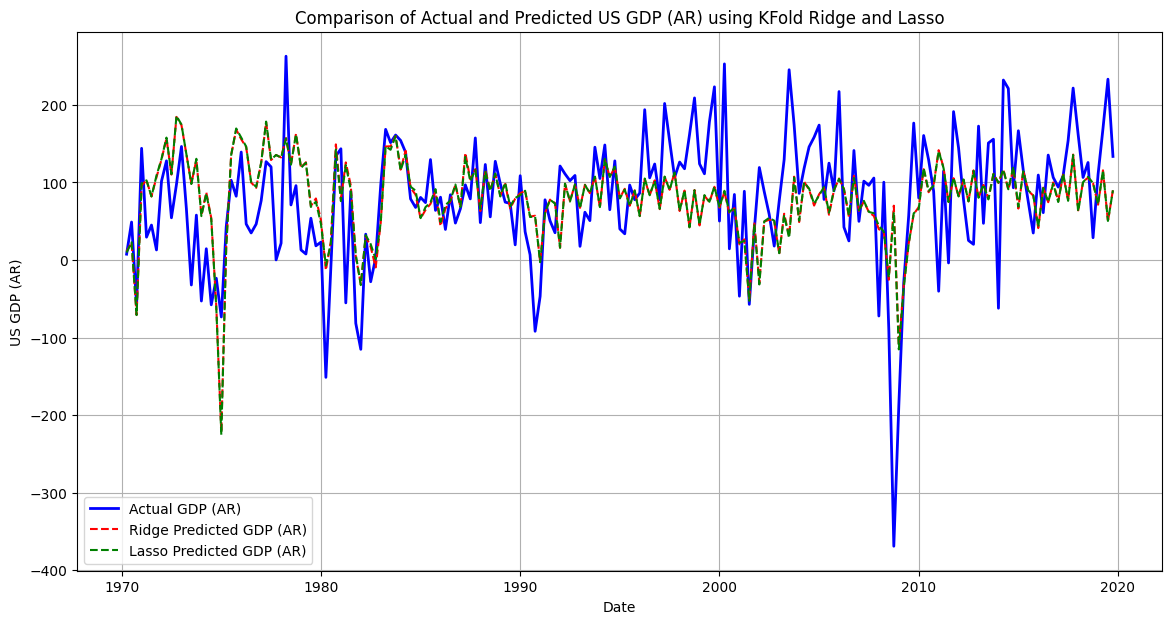

Ridge - Mean Squared Error: [5549.11113300521, 2464.7029198956093, 3764.0654182257713, 10093.889497502149, 5945.234633236283]
Ridge - Mean Absolute Error: [63.87984543852249, 34.10011698825178, 49.04069248622077, 66.46715064395119, 61.33832237096468]
Ridge - R-squared: [-0.2690484185881743, 0.5432076327904566, 0.10490353979628442, 0.2052812115487388, -0.23245911700609723]
Ridge - Adjusted R-squared: [-0.4997844946951151, 0.46015447511599405, -0.05784127114984572, 0.06078688637578222, -0.46354520144474054]
Lasso - Mean Squared Error: [5563.251251538319, 2485.4710021841793, 3732.391028610149, 9950.459905887014, 5923.188285571348]
Lasso - Mean Absolute Error: [63.90384100871588, 33.90001453631621, 48.76046165206736, 66.43616098009832, 61.36596785214875]
Lasso - R-squared: [-0.2722821788486889, 0.5393586084742115, 0.1124357239838325, 0.21657380508313862, -0.2278888647195958]
Lasso - Adjusted R-squared: [-0.5036062113666324, 0.4556056281967954, -0.04893959892819799, 0.07413267873461837, -0.

In [19]:
X = data_diff[['US unemployment', 'US 10-YEAR TREASURY BONDS YIELD', 'Non-Farm', 'US CPI',
               'US PERSONAL CURRENT TAXES (AR)', 
               'US CURRENT ACCOUNT BALANCE']].values
y = data_diff['US GDP (AR)'].values

kf = KFold(n_splits=5) # here shuffling gives worst results for R2 (adj)

ridge = Ridge(alpha=10)
lasso = Lasso(alpha=1)

ridge_mse, lasso_mse = [], []
ridge_mae, lasso_mae = [], []
ridge_r2, lasso_r2 = [], []
ridge_adj_r2, lasso_adj_r2 = [], []
ridge_predictions, lasso_predictions = [], []
actuals = []
test_dates = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    test_dates.extend(data_diff.index[test_index].tolist())

    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    ridge_predictions.extend(y_pred_ridge)

    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    lasso_predictions.extend(y_pred_lasso)

    actuals.extend(y_test)

    ridge_mse.append(mean_squared_error(y_test, y_pred_ridge))
    ridge_mae.append(mean_absolute_error(y_test, y_pred_ridge))
    ridge_r2_val = r2_score(y_test, y_pred_ridge)
    ridge_r2.append(ridge_r2_val)
    n, p = len(y_test), X_test.shape[1]
    ridge_adj_r2.append(1 - (1 - ridge_r2_val) * (n - 1) / (n - p - 1))

    lasso_mse.append(mean_squared_error(y_test, y_pred_lasso))
    lasso_mae.append(mean_absolute_error(y_test, y_pred_lasso))
    lasso_r2_val = r2_score(y_test, y_pred_lasso)
    lasso_r2.append(lasso_r2_val)
    lasso_adj_r2.append(1 - (1 - lasso_r2_val) * (n - 1) / (n - p - 1))

actuals = np.array(actuals)
ridge_predictions = np.array(ridge_predictions)
lasso_predictions = np.array(lasso_predictions)
test_dates = np.array(test_dates)

avg_ridge_mse = np.mean(ridge_mse)
avg_ridge_mae = np.mean(ridge_mae)
avg_lasso_mse = np.mean(lasso_mse)
avg_lasso_mae = np.mean(lasso_mae)



# Sort by date
sorted_indices = np.argsort(test_dates)
actuals = actuals[sorted_indices]
ridge_predictions = ridge_predictions[sorted_indices]
lasso_predictions = lasso_predictions[sorted_indices]
test_dates = test_dates[sorted_indices]

# Plotting actual vs. predicted GDP values
plt.figure(figsize=(14, 7))
plt.plot(test_dates, actuals, label='Actual GDP (AR)', color='blue', linewidth=2)
plt.plot(test_dates, ridge_predictions, label='Ridge Predicted GDP (AR)', linestyle='--', color='red')
plt.plot(test_dates, lasso_predictions, label='Lasso Predicted GDP (AR)', linestyle='--', color='green')
plt.title('Comparison of Actual and Predicted US GDP (AR) using KFold Ridge and Lasso')
plt.xlabel('Date')
plt.ylabel('US GDP (AR)')
plt.legend()
plt.grid(True)
plt.show()

# Print average metrics and R-squared values
print("Ridge - Mean Squared Error:", (ridge_mse))
print("Ridge - Mean Absolute Error:", (ridge_mae))
print("Ridge - R-squared:", (ridge_r2))
print("Ridge - Adjusted R-squared:", (ridge_adj_r2))
print("Lasso - Mean Squared Error:", (lasso_mse))
print("Lasso - Mean Absolute Error:", (lasso_mae))
print("Lasso - R-squared:", (lasso_r2))
print("Lasso - Adjusted R-squared:", (lasso_adj_r2))
print(f"Average Ridge Mean Squared Error: {avg_ridge_mse:.2f}")
print(f"Average Ridge Mean Absolute Error: {avg_ridge_mae:.2f}")
print(f"Average Lasso Mean Squared Error: {avg_lasso_mse:.2f}")
print(f"Average Lasso Mean Absolute Error: {avg_lasso_mae:.2f}")


## Ridge and Lasso Cross-Validation with Time Series

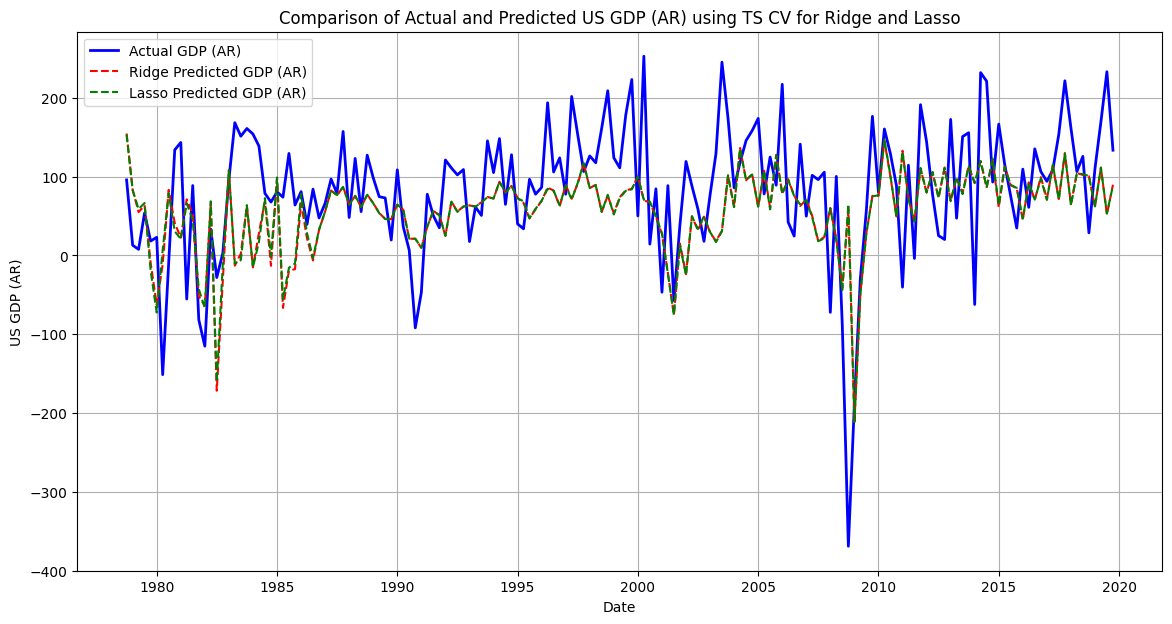

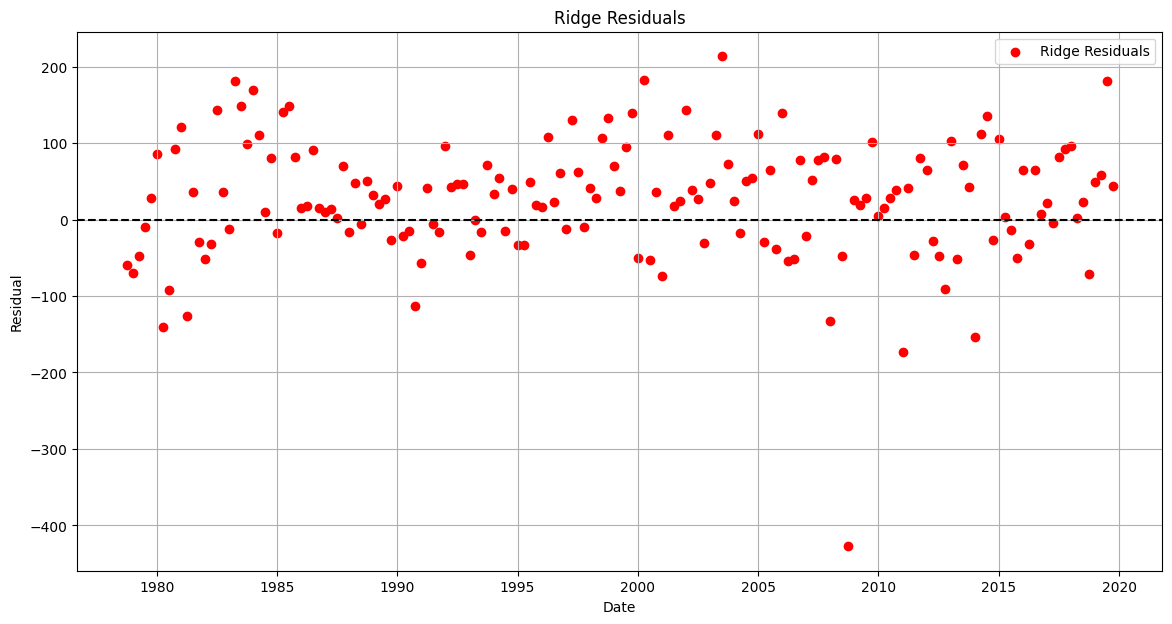

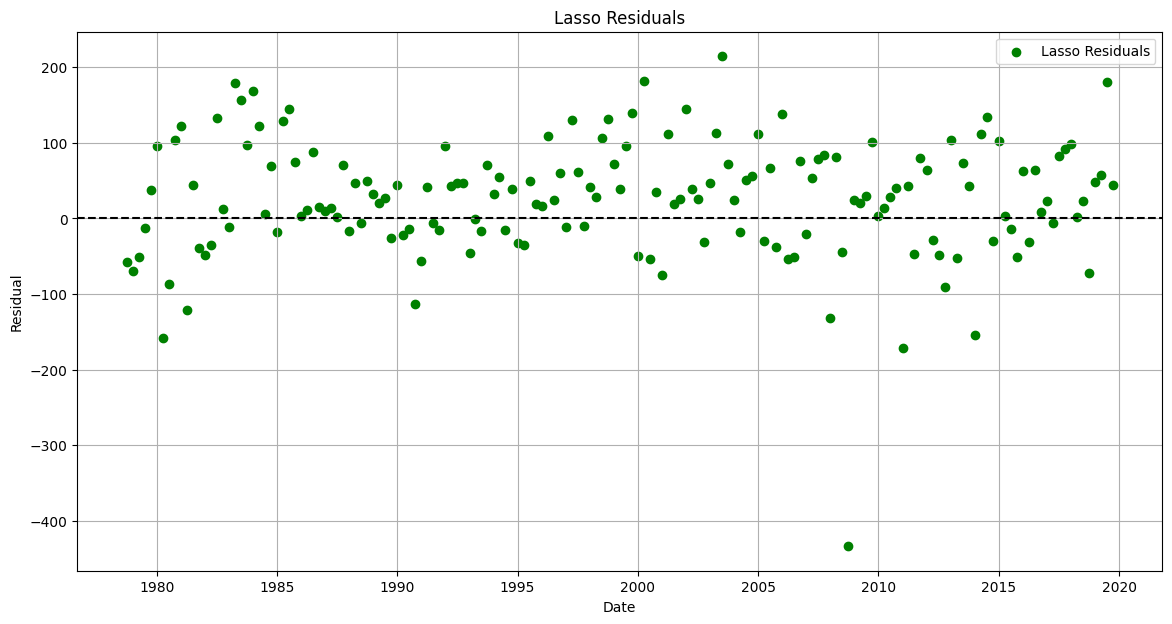

Ridge - Mean Squared Error: [8604.58673079605, 1927.7553842588663, 6187.337689371592, 11532.175174332933, 5822.766559292848]
Ridge - Mean Absolute Error: [76.88357970235865, 35.676717585632865, 64.2982046233301, 74.07078509692079, 62.93631971151958]
Ridge - R-squared: [-0.4146207983111114, 0.32169977610058487, -0.2746970228568555, 0.17790361181436987, -0.3086163175623129]
Ridge - Adjusted R-squared: [-0.7410717517675218, 0.16516895520071984, -0.5688578742853605, -0.0118109393053909, -0.6106046985382312]
Lasso - Mean Squared Error: [8649.282651481904, 1925.6556880552043, 6231.844250817942, 11713.086910063075, 5813.14303221782]
Lasso - Mean Absolute Error: [76.44257480146952, 35.61582025839397, 64.58078893601736, 74.23580080425745, 63.15477739157563]
Lasso - R-squared: [-0.4219689465697116, 0.32243857544032173, -0.28386613309803566, 0.16500692213737267, -0.3064535132605013]
Lasso - Adjusted R-squared: [-0.7501156265473374, 0.16607824669578064, -0.5801429330437362, -0.02768378813861827, -

In [20]:
X = data_diff[['US unemployment', 'US 10-YEAR TREASURY BONDS YIELD', 'Non-Farm', 'US CPI',
               'US PERSONAL CURRENT TAXES (AR)', 
               'US CURRENT ACCOUNT BALANCE']].values
y = data_diff['US GDP (AR)'].values

tscv = TimeSeriesSplit(n_splits=5)

ridge = Ridge(alpha=10)
lasso = Lasso(alpha=1)

ridge_residuals, lasso_residuals = [], []
ridge_mse, lasso_mse, ridge_mae, lasso_mae = [], [], [], []
ridge_r2, lasso_r2, ridge_adj_r2, lasso_adj_r2 = [], [], [], []
ridge_predictions, lasso_predictions = [], []
actuals, dates_for_plot = [], []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit and predict with Ridge
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    ridge_predictions.extend(y_pred_ridge)
    actuals.extend(y_test)
    dates_for_plot.extend(data_diff.iloc[test_index].index)  # Assuming data_diff index contains dates

    # Ridge residuals and metrics
    residuals_ridge = y_test - y_pred_ridge
    ridge_residuals.append(residuals_ridge)
    ridge_mse.append(mean_squared_error(y_test, y_pred_ridge))
    ridge_mae.append(mean_absolute_error(y_test, y_pred_ridge))
    ridge_r2.append(r2_score(y_test, y_pred_ridge))
    n, p = len(y_test), X_test.shape[1]
    ridge_adj_r2.append(1 - (1 - ridge_r2[-1]) * (n - 1) / (n - p - 1))

    # Fit and predict with Lasso
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    lasso_predictions.extend(y_pred_lasso)

    # Lasso residuals and metrics
    residuals_lasso = y_test - y_pred_lasso
    lasso_residuals.append(residuals_lasso)
    lasso_mse.append(mean_squared_error(y_test, y_pred_lasso))
    lasso_mae.append(mean_absolute_error(y_test, y_pred_lasso))
    lasso_r2.append(r2_score(y_test, y_pred_lasso))
    lasso_adj_r2.append(1 - (1 - lasso_r2[-1]) * (n - 1) / (n - p - 1))
avg_ridge_mse = np.mean(ridge_mse)
avg_ridge_mae = np.mean(ridge_mae)
avg_lasso_mse = np.mean(lasso_mse)
avg_lasso_mae = np.mean(lasso_mae)

# Plotting actual vs. predicted GDP values
plt.figure(figsize=(14, 7))
plt.plot(dates_for_plot, actuals, label='Actual GDP (AR)', color='blue', linewidth=2)
plt.plot(dates_for_plot, ridge_predictions, label='Ridge Predicted GDP (AR)', linestyle='--', color='red')
plt.plot(dates_for_plot, lasso_predictions, label='Lasso Predicted GDP (AR)', linestyle='--', color='green')
plt.title('Comparison of Actual and Predicted US GDP (AR) using TS CV for Ridge and Lasso')
plt.xlabel('Date')
plt.ylabel('US GDP (AR)')
plt.legend()
plt.grid(True)
plt.show()
ridge_residuals_array = np.concatenate(ridge_residuals)
lasso_residuals_array = np.concatenate(lasso_residuals)

# Plot Ridge residuals
plt.figure(figsize=(14, 7))
plt.scatter(dates_for_plot, ridge_residuals_array, label='Ridge Residuals', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Ridge Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.grid(True)
plt.show()

# Plot Lasso residuals
plt.figure(figsize=(14, 7))
plt.scatter(dates_for_plot, lasso_residuals_array, label='Lasso Residuals', color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Lasso Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.grid(True)
plt.show()


print("Ridge - Mean Squared Error:", (ridge_mse))
print("Ridge - Mean Absolute Error:", (ridge_mae))
print("Ridge - R-squared:", (ridge_r2))
print("Ridge - Adjusted R-squared:", (ridge_adj_r2))
print("Lasso - Mean Squared Error:", (lasso_mse))
print("Lasso - Mean Absolute Error:", (lasso_mae))
print("Lasso - R-squared:", (lasso_r2))
print("Lasso - Adjusted R-squared:", (lasso_adj_r2))

print(f"Average Ridge Mean Squared Error: {avg_ridge_mse:.2f}")
print(f"Average Ridge Mean Absolute Error: {avg_ridge_mae:.2f}")
print(f"Average Lasso Mean Squared Error: {avg_lasso_mse:.2f}")
print(f"Average Lasso Mean Absolute Error: {avg_lasso_mae:.2f}")


## **Polynomial Regression Model Explanation**

                            OLS Regression Results                            
Dep. Variable:            US GDP (AR)   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     5.333
Date:                Tue, 21 May 2024   Prob (F-statistic):           2.94e-11
Time:                        10:23:56   Log-Likelihood:                -860.30
No. Observations:                 159   AIC:                             1777.
Df Residuals:                     131   BIC:                             1863.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.0359     17.596      4.037      0.0

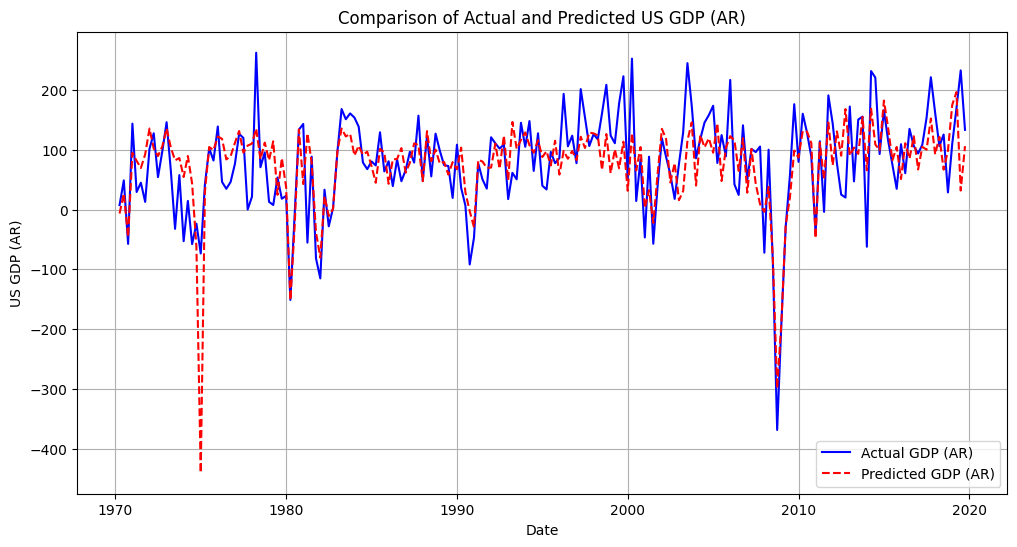

Mean Squared Error (MSE): 7148.813954276132
Mean Absolute Error (MAE): 57.53300955017621


In [21]:
data_diff.dropna(inplace=True)

X = data_diff[['US unemployment', 'US 10-YEAR TREASURY BONDS YIELD', 'Non-Farm', 'US CPI',
               'US PERSONAL CURRENT TAXES (AR)', 
               'US CURRENT ACCOUNT BALANCE']]

y = data_diff['US GDP (AR)']

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

X_poly = sm.add_constant(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2)

model = sm.OLS(y_train, X_train)
results = model.fit()

y_pred_full = results.predict(X_poly)

sorted_idx = np.argsort(data_diff.index)
sorted_dates = data_diff.index[sorted_idx]
sorted_y = y.iloc[sorted_idx]
sorted_y_pred = y_pred_full[sorted_idx]
print(results.summary())

plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, sorted_y, label='Actual GDP (AR)', color='blue')
plt.plot(sorted_dates, sorted_y_pred, label='Predicted GDP (AR)', color='red', linestyle='--')
plt.title('Comparison of Actual and Predicted US GDP (AR)')
plt.xlabel('Date')
plt.ylabel('US GDP (AR)')
plt.legend()
plt.grid(True)
plt.show()

# Displaying MSE and MAE for test set
mse = mean_squared_error(y_test, results.predict(X_test))
mae = mean_absolute_error(y_test, results.predict(X_test))

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)



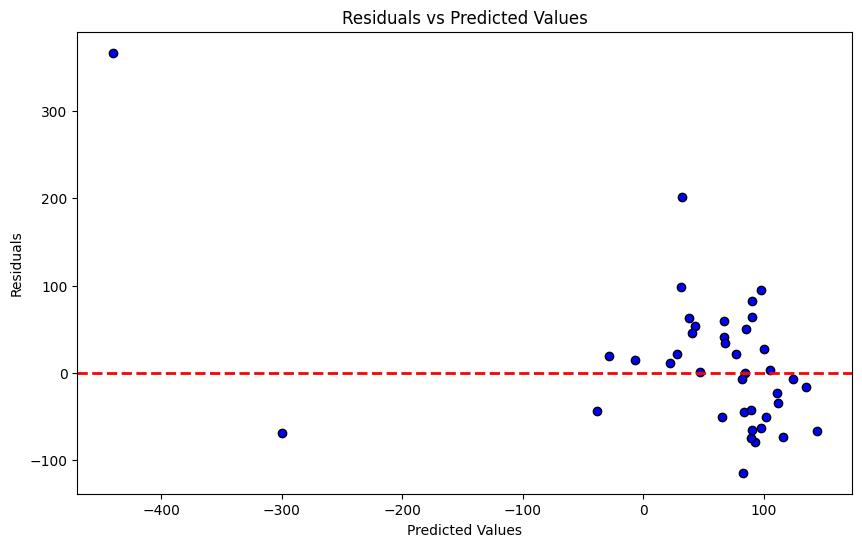

In [22]:
residuals = y_test - results.predict(X_test)

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(results.predict(X_test), residuals, color='blue', edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


In [23]:
features = ['US unemployment', 'US 10-YEAR TREASURY BONDS YIELD', 'Non-Farm', 'US CPI',
            'US PERSONAL CURRENT TAXES (AR)', 
            'US CURRENT ACCOUNT BALANCE']

X_original = data_diff[features]

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_original)

if hasattr(poly, 'get_feature_names_out'):
    column_names = poly.get_feature_names_out(features)
else:
    column_names = poly.get_feature_names(features)

X_poly_df = pd.DataFrame(X_poly, columns=column_names)

X_poly_df = add_constant(X_poly_df)

# Calculate VIF for each polynomial feature
vif_data_poly = pd.DataFrame()
vif_data_poly["Variable"] = X_poly_df.columns
vif_data_poly["VIF"] = [variance_inflation_factor(X_poly_df.values, i) for i in range(X_poly_df.shape[1])]

print(vif_data_poly)


                                             Variable        VIF
0                                                   1   8.730748
1                                     US unemployment   5.193451
2                     US 10-YEAR TREASURY BONDS YIELD   8.768566
3                                            Non-Farm   7.183731
4                                              US CPI   4.142160
5                      US PERSONAL CURRENT TAXES (AR)   7.984696
6                          US CURRENT ACCOUNT BALANCE   5.682752
7                                   US unemployment^2   7.771715
8     US unemployment US 10-YEAR TREASURY BONDS YIELD   2.121021
9                            US unemployment Non-Farm  10.651325
10                             US unemployment US CPI   6.176761
11     US unemployment US PERSONAL CURRENT TAXES (AR)  11.169979
12         US unemployment US CURRENT ACCOUNT BALANCE  10.600157
13                  US 10-YEAR TREASURY BONDS YIELD^2   4.582164
14           US 10-YEAR T

## Cross-Validation for Polynomial Regression with K-Fold and TS

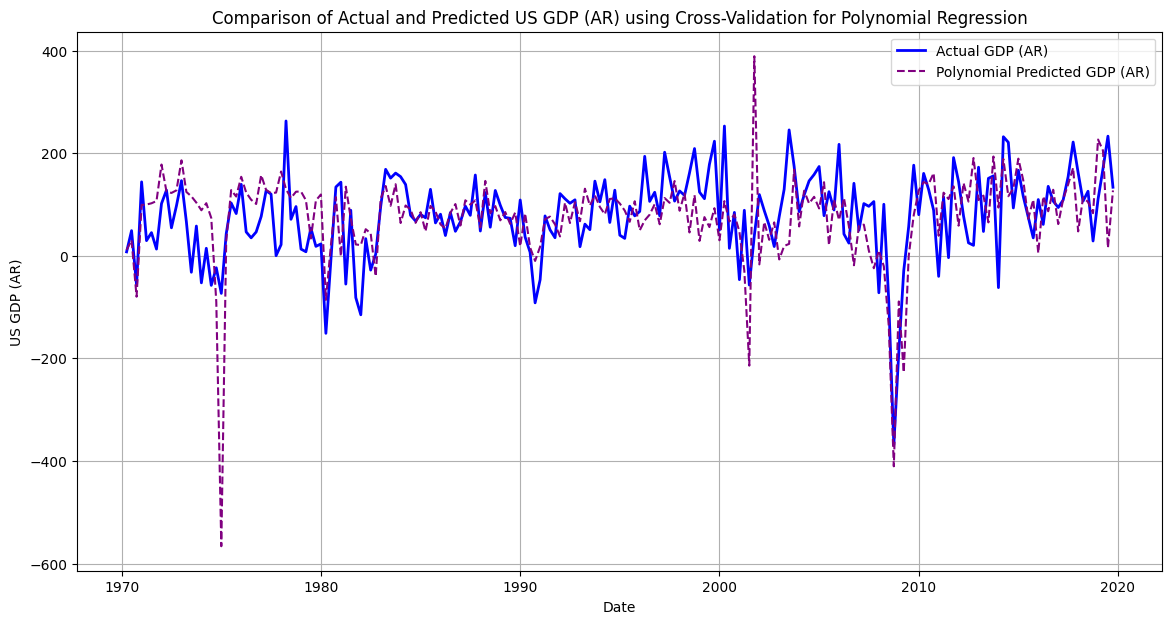

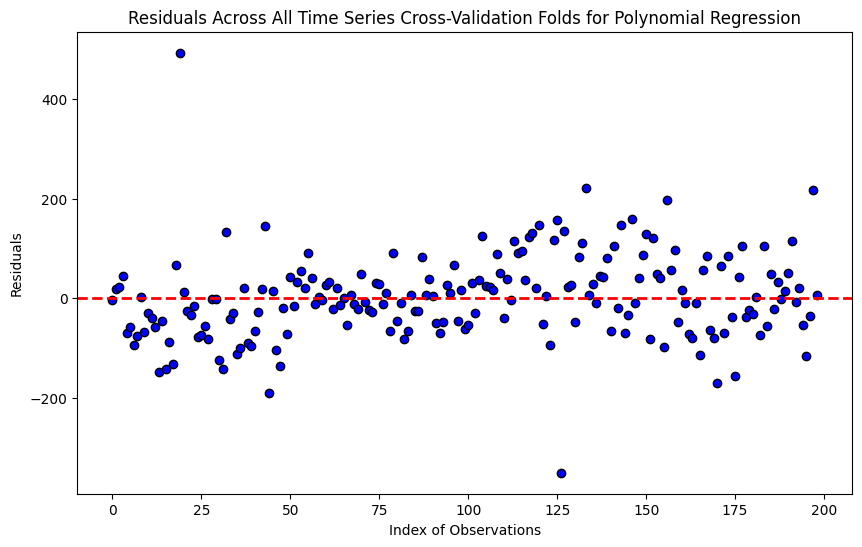

Mean Squared Error: [11787.223076710348, 3451.21935334548, 3624.963194672692, 12003.740039139602, 6097.464129645821]
Mean Absolute Error: [74.08856000771523, 41.46269050513466, 48.99936243937685, 86.0092729736158, 61.29379328394587]
R-squared: [-1.695667188223036, 0.3603729498397954, 0.13798211151981088, 0.054913594690173206, -0.26401659830016233]
Adjusted R-squared: [-8.557365485518037, -1.2677686323861797, -2.056245240975216, -2.3507608915530223, -3.8032630735406165]
Average Mean Squared Error: 7392.92
Average Mean Absolute Error: 62.37


In [24]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

model = LinearRegression()

kf = KFold(n_splits=5)

mse_scores = []
mae_scores = []
residuals_list = []
r2_scores = []
adj_r2_scores = []
Poly_predictions = []
actuals, dates_for_plot = [], []

for train_index, test_index in kf.split(X_poly):

    X_train, X_test = X_poly[train_index], X_poly[test_index]

    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    
    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)
    Poly_predictions.extend(y_pred)

    dates_for_plot.extend(data_diff.iloc[test_index].index)


    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2 = r2_score(y_test, y_pred)
    n, p = len(y_test), X_test.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)


    residuals = y_test - y_pred
    residuals_list.extend(residuals)

    actuals.extend(y_test)
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)
# Convert residuals list to a NumPy array for easier manipulation
residuals_array = np.array(residuals_list)

# Plotting actual vs. predicted GDP values
plt.figure(figsize=(14, 7))
plt.plot(dates_for_plot, actuals, label='Actual GDP (AR)', color='blue', linewidth=2)
plt.plot(dates_for_plot, Poly_predictions, label='Polynomial Predicted GDP (AR)', linestyle='--', color='purple')
plt.title('Comparison of Actual and Predicted US GDP (AR) using Cross-Validation for Polynomial Regression')
plt.xlabel('Date')
plt.ylabel('US GDP (AR)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals_array)), residuals_array, color='blue', edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Index of Observations')
plt.ylabel('Residuals')
plt.title('Residuals Across All Time Series Cross-Validation Folds for Polynomial Regression')
plt.show()

# Print the average MSE and MAE
print("Mean Squared Error:",(mse_scores))
print("Mean Absolute Error:",(mae_scores))
print("R-squared:", (r2_scores))
print("Adjusted R-squared:", (adj_r2_scores))

print(f"Average Mean Squared Error: {avg_mse:.2f}")
print(f"Average Mean Absolute Error: {avg_mae:.2f}")


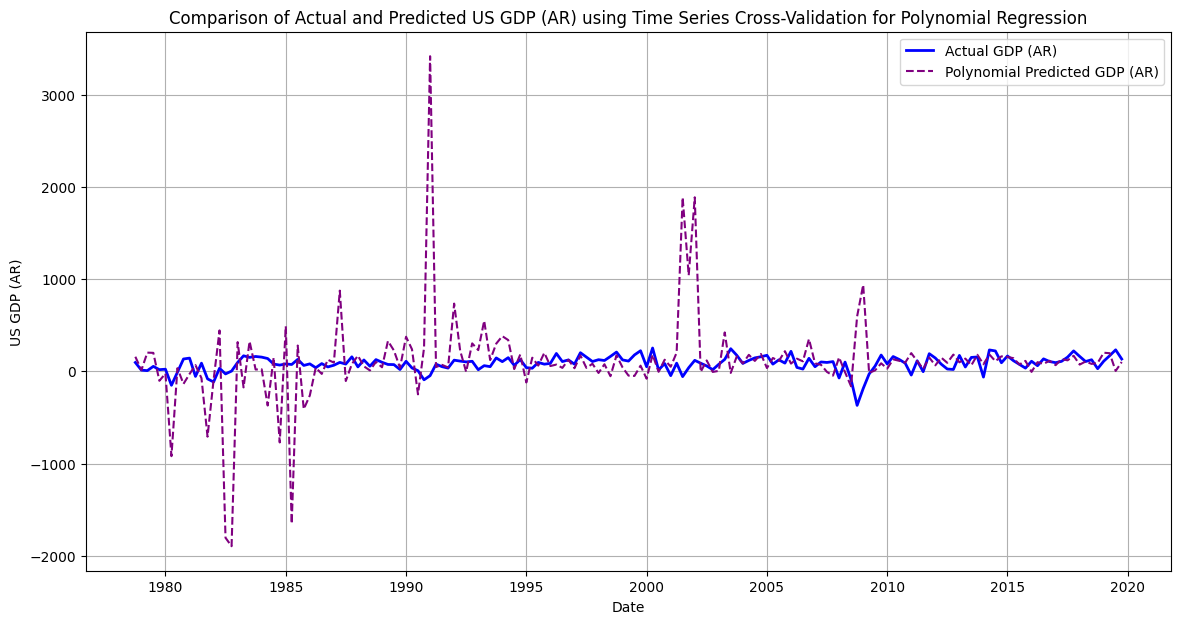

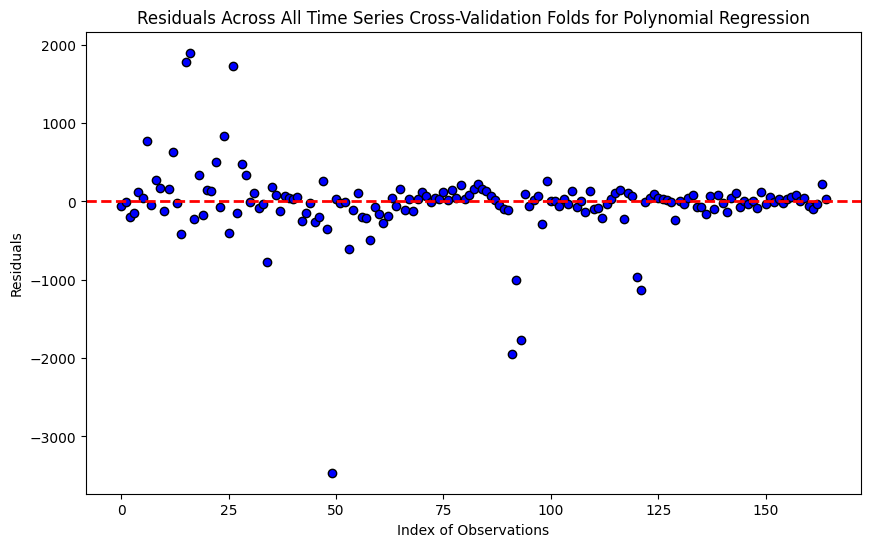

Mean Squared Error: [389881.7136622125, 422518.18262326566, 251413.4113727656, 77671.15641832593, 6381.154218812665]
Mean Absolute Error: [380.7746132937946, 275.1295387673076, 227.0747254755104, 139.5654975643353, 63.982138149369874]
R-squared: [-63.097765329482385, -147.66729472791351, -50.79544790866245, -4.536958656318745, -0.4341091044244063]
Adjusted R-squared: [-511.7821226358591, -1188.3383578233081, -413.3635832692996, -43.29566925054996, -10.47287283539525]
Average Mean Squared Error: 229573.12
Average Mean Absolute Error: 217.31


In [25]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

model = LinearRegression()

tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
mae_scores = []
residuals_list = []
r2_scores = []
adj_r2_scores = []
Poly_predictions = []
actuals, dates_for_plot = [], []

for train_index, test_index in tscv.split(X_poly):

    X_train, X_test = X_poly[train_index], X_poly[test_index]

    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    Poly_predictions.extend(y_pred)

    dates_for_plot.extend(data_diff.iloc[test_index].index)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2 = r2_score(y_test, y_pred)
    n, p = len(y_test), X_test.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    r2_scores.append(r2)
    adj_r2_scores.append(adj_r2)

    residuals = y_test - y_pred
    residuals_list.extend(residuals)

    actuals.extend(y_test)

residuals_array = np.array(residuals_list)
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)

plt.figure(figsize=(14, 7))
plt.plot(dates_for_plot, actuals, label='Actual GDP (AR)', color='blue', linewidth=2)
plt.plot(dates_for_plot, Poly_predictions, label='Polynomial Predicted GDP (AR)', linestyle='--', color='purple')
plt.title('Comparison of Actual and Predicted US GDP (AR) using Time Series Cross-Validation for Polynomial Regression')
plt.xlabel('Date')
plt.ylabel('US GDP (AR)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals_array)), residuals_array, color='blue', edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Index of Observations')
plt.ylabel('Residuals')
plt.title('Residuals Across All Time Series Cross-Validation Folds for Polynomial Regression')
plt.show()

# Print the average MSE and MAE
print("Mean Squared Error:",(mse_scores))
print("Mean Absolute Error:",(mae_scores))
print("R-squared:", (r2_scores))
print("Adjusted R-squared:", (adj_r2_scores))

print(f"Average Mean Squared Error: {avg_mse:.2f}")
print(f"Average Mean Absolute Error: {avg_mae:.2f}")


## Applying Ridge and Lasso Regression using Cross-Validation

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5)
ridge_cv.fit(X_train_scaled, y_train)
print("Best Ridge alpha:", ridge_cv.alpha_)

lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 13), cv=5, max_iter=50000)
lasso_cv.fit(X_train_scaled, y_train)
print("Best Lasso alpha:", lasso_cv.alpha_)

Best Ridge alpha: 100.0
Best Lasso alpha: 10.0


## With K-Fold

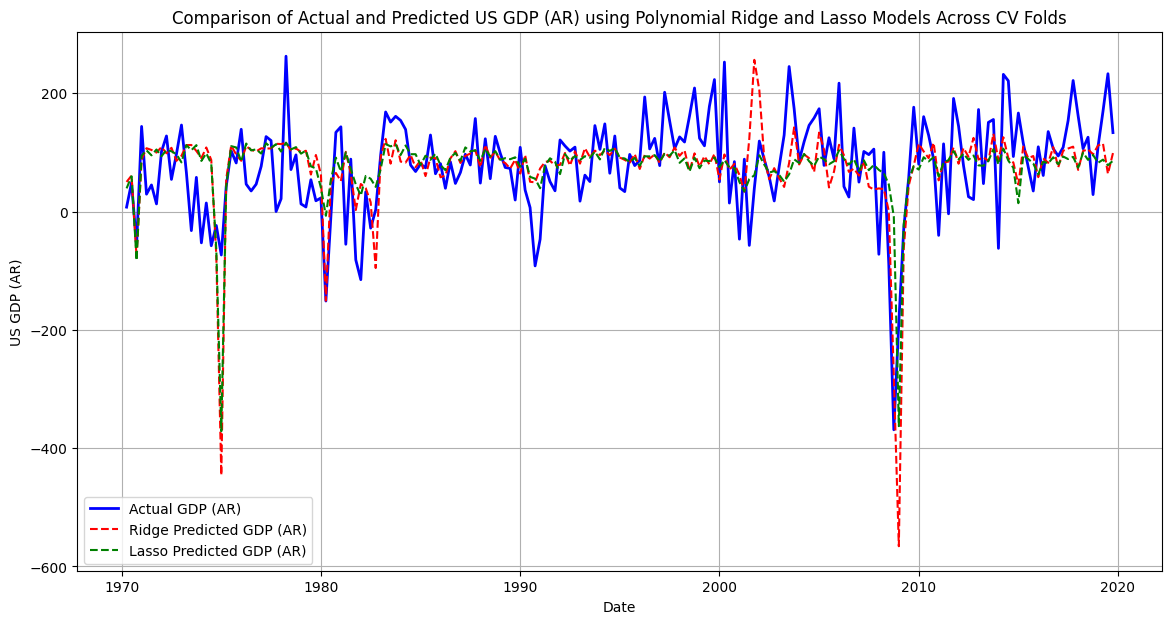

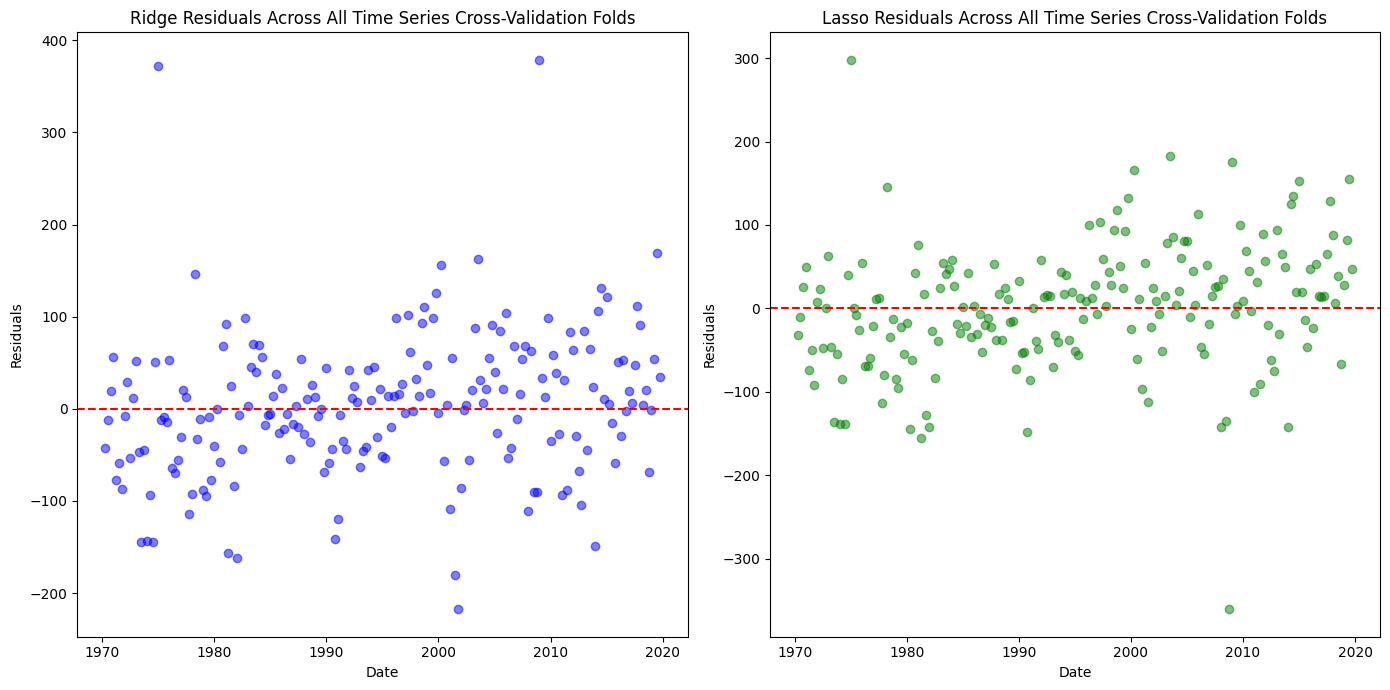

Ridge - MSE: [8279.446451205433, 3070.4154541355542, 3495.496574719019, 10163.342567359266, 5155.474824221257]
Ridge - MAE: [64.89388982160835, 40.392297532459395, 46.02107522728714, 72.61208834148931, 58.076997105362864]
Ridge - R-squared: [-0.893459722439814, 0.4309487231545338, 0.16876933234598246, 0.19981298648596912, -0.06874031751176624]
Ridge - Adjusted R-squared: [-1.2377251265197802, 0.32748485463717625, 0.017636483681615522, 0.054324438574327116, -0.2691291270452223]
Lasso - MSE: [6661.39079406696, 3415.424975901765, 3565.2863984095484, 8992.579303947747, 5597.716099217648]
Lasso - MAE: [60.11230070161935, 44.43705189904652, 47.3986257470922, 65.07355913287631, 61.75144522326931]
Lasso - R-squared: [-0.5234201028210983, 0.3670068521544805, 0.15217328068302283, 0.2919902945981584, -0.16041782477761624]
Lasso - Adjusted R-squared: [-0.8004055760612978, 0.2519171889098406, -0.001977031920064043, 0.16326125725236906, -0.3779961669234193]
Average Ridge Mean Squared Error: 6032.84


In [27]:
X = data_diff[['US unemployment', 'US 10-YEAR TREASURY BONDS YIELD', 'Non-Farm', 'US CPI',
               'US PERSONAL CURRENT TAXES (AR)', 'US CURRENT ACCOUNT BALANCE']]
y = data_diff['US GDP (AR)']

# Setup a pipeline that includes scaling and regression
ridge_pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), Ridge(alpha=100))
lasso_pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), Lasso(alpha=10, max_iter=10000))

kf = KFold(n_splits=5)

all_actuals = np.array([])
all_ridge_preds = np.array([])
all_lasso_preds = np.array([])

ridge_residuals = []
lasso_residuals = []

ridge_mse = []
lasso_mse = []

ridge_mae = []
lasso_mae = []

ridge_r2 = []
lasso_r2 = []

ridge_adj_r2 = []
lasso_adj_r2 = []

time_indexed_ridge_residuals = []
time_indexed_lasso_residuals = []

dates_for_plot = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

 
    ridge_pipeline.fit(X_train, y_train)
    y_pred_ridge = ridge_pipeline.predict(X_test)

    residuals_ridge = y_test - y_pred_ridge
    ridge_residuals.extend(residuals_ridge)
    ridge_mse.append(mean_squared_error(y_test, y_pred_ridge))
    ridge_mae.append(mean_absolute_error(y_test, y_pred_ridge))
    ridge_r2.append(r2_score(y_test, y_pred_ridge))
    ridge_adj_r2.append(1 - (1 - r2_score(y_test, y_pred_ridge)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))


    lasso_pipeline.fit(X_train, y_train)
    y_pred_lasso = lasso_pipeline.predict(X_test)

    residuals_lasso = y_test - y_pred_lasso
    lasso_residuals.extend(residuals_lasso)
    lasso_mse.append(mean_squared_error(y_test, y_pred_lasso))
    lasso_mae.append(mean_absolute_error(y_test, y_pred_lasso))
    lasso_r2.append(r2_score(y_test, y_pred_lasso))
    lasso_adj_r2.append(1 - (1 - r2_score(y_test, y_pred_lasso)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))

   
    all_actuals = np.concatenate((all_actuals, y_test))
    all_ridge_preds = np.concatenate((all_ridge_preds, y_pred_ridge))
    all_lasso_preds = np.concatenate((all_lasso_preds, y_pred_lasso))

    dates_for_plot.extend(data_diff.iloc[test_index].index)

    time_indexed_ridge_residuals.append(pd.Series(y_test - y_pred_ridge, index=X_test.index))
    time_indexed_lasso_residuals.append(pd.Series(y_test - y_pred_lasso, index=X_test.index))

# Concatenate all residuals into a single Series for each model
all_ridge_residuals = pd.concat(time_indexed_ridge_residuals)
all_lasso_residuals = pd.concat(time_indexed_lasso_residuals)

# Sort by date
dates_for_plot = np.array(dates_for_plot)
sorted_indices = np.argsort(dates_for_plot)
dates_for_plot = dates_for_plot[sorted_indices]
all_actuals = all_actuals[sorted_indices]
all_ridge_preds = all_ridge_preds[sorted_indices]
all_lasso_preds = all_lasso_preds[sorted_indices]
avg_ridge_mse = np.mean(ridge_mse)
avg_ridge_mae = np.mean(ridge_mae)
avg_lasso_mse = np.mean(lasso_mse)
avg_lasso_mae = np.mean(lasso_mae)
# Plotting the actual and predicted values
plt.figure(figsize=(14, 7))
plt.plot(dates_for_plot, all_actuals, label='Actual GDP (AR)', color='blue', linewidth=2)
plt.plot(dates_for_plot, all_ridge_preds, label='Ridge Predicted GDP (AR)', linestyle='--', color='red')
plt.plot(dates_for_plot, all_lasso_preds, label='Lasso Predicted GDP (AR)', linestyle='--', color='green')
plt.title('Comparison of Actual and Predicted US GDP (AR) using Polynomial Ridge and Lasso Models Across CV Folds')
plt.xlabel('Date')
plt.ylabel('US GDP (AR)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting residuals for Ridge
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.scatter(all_ridge_residuals.index, all_ridge_residuals, color='blue', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Ridge Residuals Across All Time Series Cross-Validation Folds')
plt.xlabel('Date')
plt.ylabel('Residuals')

# Plotting residuals for Lasso
plt.subplot(1, 2, 2)
plt.scatter(all_lasso_residuals.index, all_lasso_residuals, color='green', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Lasso Residuals Across All Time Series Cross-Validation Folds')
plt.xlabel('Date')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Print average MSE and MAE for both models
print("Ridge - MSE:", ridge_mse)
print("Ridge - MAE:", ridge_mae)
print("Ridge - R-squared:", ridge_r2)
print("Ridge - Adjusted R-squared:", ridge_adj_r2)
print("Lasso - MSE:", lasso_mse)
print("Lasso - MAE:", lasso_mae)
print("Lasso - R-squared:", lasso_r2)
print("Lasso - Adjusted R-squared:", lasso_adj_r2)

print(f"Average Ridge Mean Squared Error: {avg_ridge_mse:.2f}")
print(f"Average Ridge Mean Absolute Error: {avg_ridge_mae:.2f}")
print(f"Average Lasso Mean Squared Error: {avg_lasso_mse:.2f}")
print(f"Average Lasso Mean Absolute Error: {avg_lasso_mae:.2f}")

## With TS

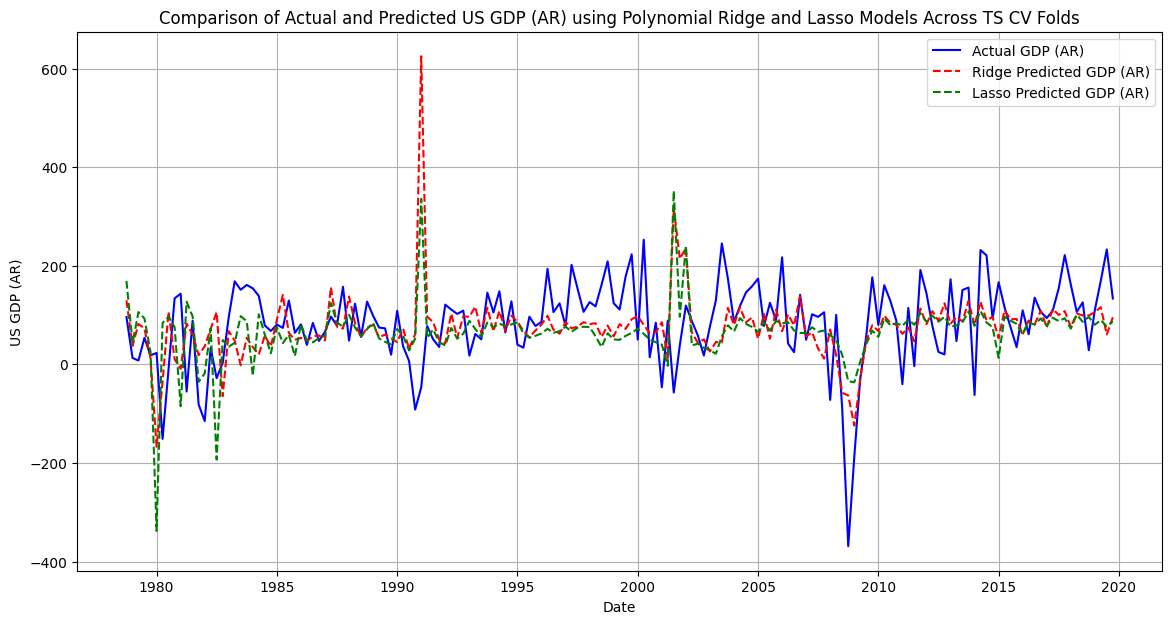

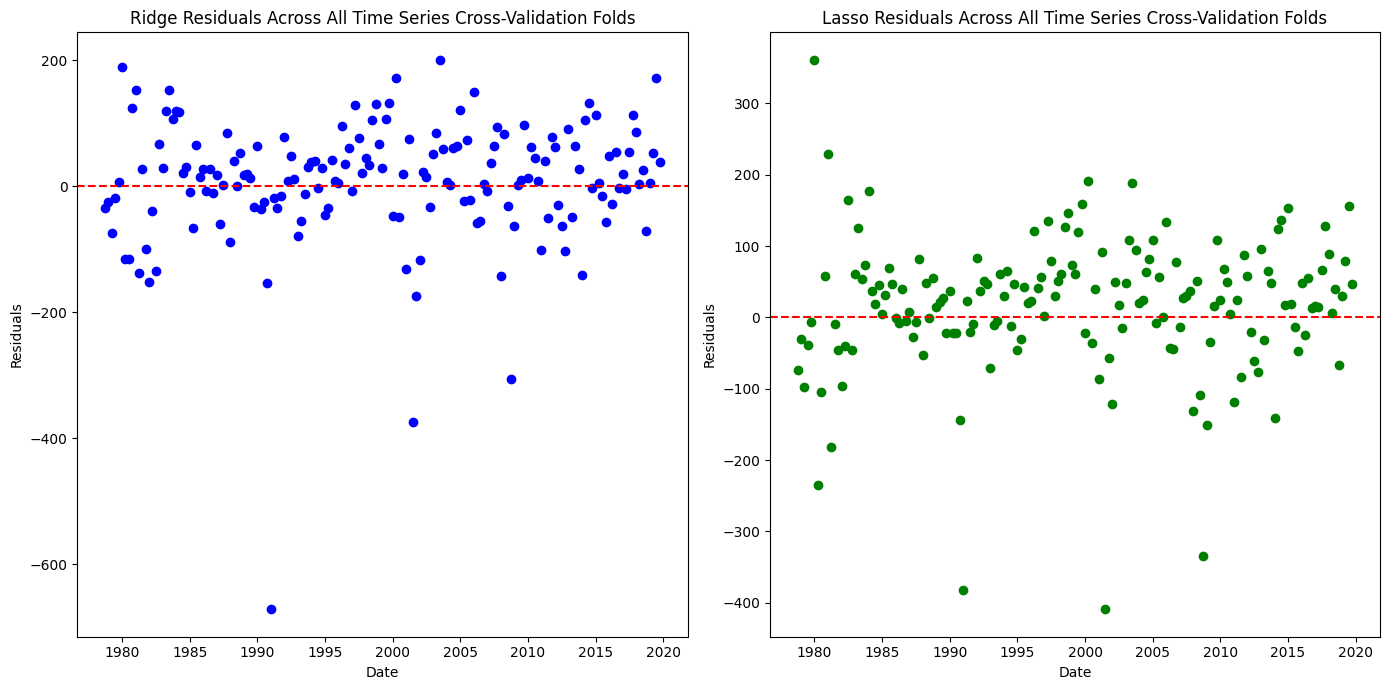

Ridge - MSE: [8381.2951408498, 16151.52582305152, 10880.55803508137, 8234.666524087519, 5311.418735270788]
Ridge - MAE: [74.04102932869888, 58.45994153543874, 76.81767392316569, 65.27828941091853, 58.19724634736655]
Ridge - R-squared: [-0.37791096701899307, -4.683077672380591, -1.24158040673356, 0.4129737447595567, -0.19369532602826167]
Ridge - Adjusted R-squared: [-0.6958904209464529, -5.994557135237651, -1.7588681929028431, 0.27750614739637747, -0.4691634781886298]
Lasso - MSE: [12664.80629662356, 6638.345942176299, 12118.146385030448, 9422.83312300839, 5860.011030447564]
Lasso - MAE: [79.3501275907829, 48.09790989187899, 81.04801749138275, 71.51222127400358, 62.93409645794782]
Lasso - R-squared: [-1.0821335125443876, -1.3357691414935795, -1.4965447006514894, 0.32827268405162735, -0.31698668965189203]
Lasso - Adjusted R-squared: [-1.5626258615930926, -1.8747927895305594, -2.072670400801833, 0.1732586880635414, -0.6209066949561748]
Average Mean Squared Error: 229573.12
Average Mean Ab

In [28]:
X = data_diff[['US unemployment', 'US 10-YEAR TREASURY BONDS YIELD', 'Non-Farm', 'US CPI',
               'US PERSONAL CURRENT TAXES (AR)', 'US CURRENT ACCOUNT BALANCE']]
y = data_diff['US GDP (AR)']

ridge_pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), Ridge(alpha=100))
lasso_pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), Lasso(alpha=10, max_iter=10000))

tscv = TimeSeriesSplit(n_splits=5)

all_actuals = np.array([])
all_ridge_preds = np.array([])
all_lasso_preds = np.array([])

ridge_residuals = []
lasso_residuals = []

ridge_mse = []
lasso_mse = []

ridge_mae = []
lasso_mae = []

ridge_r2 = []
lasso_r2 = []

ridge_adj_r2 = []
lasso_adj_r2 = []

time_indexed_ridge_residuals = []
time_indexed_lasso_residuals = []

actuals, dates_for_plot = [], []


for train_index, test_index in tscv.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit and predict using Ridge
    ridge_pipeline.fit(X_train, y_train)
    y_pred_ridge = ridge_pipeline.predict(X_test)

    residuals_ridge = y_test - y_pred_ridge
    ridge_residuals.extend(residuals_ridge)
    ridge_mse.append(mean_squared_error(y_test, y_pred_ridge))
    ridge_mae.append(mean_absolute_error(y_test, y_pred_ridge))
    ridge_r2.append(r2_score(y_test, y_pred_ridge))
    ridge_adj_r2.append(1 - (1-r2_score(y_test, y_pred_ridge)) * (len(y_test)-1) / (len(y_test)-X_test.shape[1]-1))

    actual_values.extend(y_test)


    lasso_pipeline.fit(X_train, y_train)
    y_pred_lasso = lasso_pipeline.predict(X_test)

    residuals_lasso = y_test - y_pred_lasso
    lasso_residuals.extend(residuals_lasso)
    lasso_mse.append(mean_squared_error(y_test, y_pred_lasso))
    lasso_mae.append(mean_absolute_error(y_test, y_pred_lasso))
    lasso_r2.append(r2_score(y_test, y_pred_lasso))
    lasso_adj_r2.append(1 - (1-r2_score(y_test, y_pred_lasso)) * (len(y_test)-1) / (len(y_test)-X_test.shape[1]-1))


    all_actuals = np.concatenate((all_actuals, y_test))
    all_ridge_preds = np.concatenate((all_ridge_preds, y_pred_ridge))
    all_lasso_preds = np.concatenate((all_lasso_preds, y_pred_lasso))

    dates_for_plot.extend(data_diff.iloc[test_index].index)

    time_indexed_ridge_residuals.append(pd.Series(y_test - y_pred_ridge, index=X_test.index))
    time_indexed_lasso_residuals.append(pd.Series(y_test - y_pred_lasso, index=X_test.index))

all_ridge_residuals = pd.concat(time_indexed_ridge_residuals)
all_lasso_residuals = pd.concat(time_indexed_lasso_residuals)
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)


# Plotting the actual and predicted values
plt.figure(figsize=(14, 7))
plt.plot(dates_for_plot, all_actuals, label='Actual GDP (AR)', color='blue')
plt.plot(dates_for_plot, all_ridge_preds, label='Ridge Predicted GDP (AR)', linestyle='--', color='red')
plt.plot(dates_for_plot, all_lasso_preds, label='Lasso Predicted GDP (AR)', linestyle='--', color='green')
plt.title('Comparison of Actual and Predicted US GDP (AR) using Polynomial Ridge and Lasso Models Across TS CV Folds')
plt.xlabel('Date')
plt.ylabel('US GDP (AR)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting residuals for Ridge
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.scatter(all_ridge_residuals.index, all_ridge_residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('Ridge Residuals Across All Time Series Cross-Validation Folds')
plt.xlabel('Date')
plt.ylabel('Residuals')

# Plotting residuals for Lasso
plt.subplot(1, 2, 2)
plt.scatter(all_lasso_residuals.index, all_lasso_residuals, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title('Lasso Residuals Across All Time Series Cross-Validation Folds')
plt.xlabel('Date')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Print average MSE and MAE for both models
print("Ridge - MSE:", (ridge_mse))
print("Ridge - MAE:",(ridge_mae))
print("Ridge - R-squared:",(ridge_r2))
print("Ridge - Adjusted R-squared:",(ridge_adj_r2))
print("Lasso - MSE:",(lasso_mse))
print("Lasso - MAE:",(lasso_mae))
print("Lasso - R-squared:",(lasso_r2))
print("Lasso - Adjusted R-squared:", (lasso_adj_r2))
print(f"Average Mean Squared Error: {avg_mse:.2f}")
print(f"Average Mean Absolute Error: {avg_mae:.2f}")

## **Ensemble Forecasting Models**

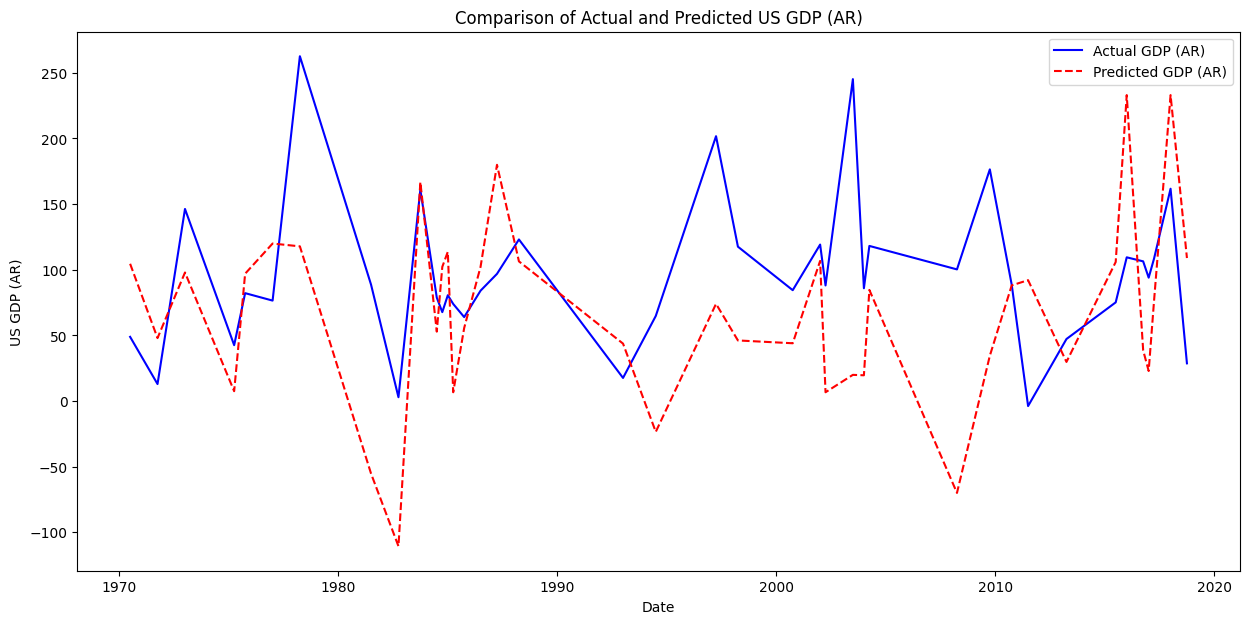

Mean Squared Error (MSE) on Test Set: 6780.99
Mean Absolute Error (MAE) on Test Set: 65.07
R-squared (R2) on Test Set: -1.08
Adjusted R-squared (R2 adjusted) on Test Set: -1.46
40


In [29]:
X = data_diff[['US unemployment', 'US 10-YEAR TREASURY BONDS YIELD', 'Non-Farm', 'US CPI',
               'US PERSONAL CURRENT TAXES (AR)', 'US CURRENT ACCOUNT BALANCE']]
y = data_diff['US GDP (AR)']
data_diff.sort_index(inplace=True)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_test.sort_index(inplace=True)  
y_test = y_test.reindex(X_test.index)  # Align y_test with the sorted X_test

model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.1, max_depth=5000)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)

# Plot the actual vs predicted values
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual GDP (AR)', color='blue')  # Ensure the index is used for x-axis
plt.plot(X_test.index, y_pred_test, label='Predicted GDP (AR)', linestyle='--', color='red')
plt.title('Comparison of Actual and Predicted US GDP (AR)')
plt.xlabel('Date')
plt.ylabel('US GDP (AR)')
plt.legend()
plt.show()

r2 = r2_score(y_test, y_pred_test)
n_obs = len(X_test)
n_features = X_test.shape[1]
r2_adjusted = 1 - ((1 - r2) * (n_obs - 1) / (n_obs - n_features - 1))

print("Mean Squared Error (MSE) on Test Set: {:.2f}".format(mse))
print("Mean Absolute Error (MAE) on Test Set: {:.2f}".format(mae))
print("R-squared (R2) on Test Set: {:.2f}".format(r2))
print("Adjusted R-squared (R2 adjusted) on Test Set: {:.2f}".format(r2_adjusted))
print(n_obs)


## Gradient Boosting Regressor with Cross_validation with K-Fold

Mean Squared Error: [6349.437718781486, 3324.1486527044776, 5147.2915339703995, 10803.447047011285, 6590.279147083987]
Mean Absolute Error: [64.30894638717936, 39.430485759038774, 59.78082102107648, 75.76586021646911, 67.31622642876728]
R-squared: [-0.4520783063827287, 0.3839234255097951, -0.22402825662503068, 0.14941585694763182, -0.36617814426232087]
Adjusted R-squared: [-0.7160925439068613, 0.2719095028752124, -0.4465788487386726, -0.00523580542552593, -0.622336546311506]
Averge Mean Squared Error: 6442.920819910328
Average Mean Absolute Error: 61.3204679625062


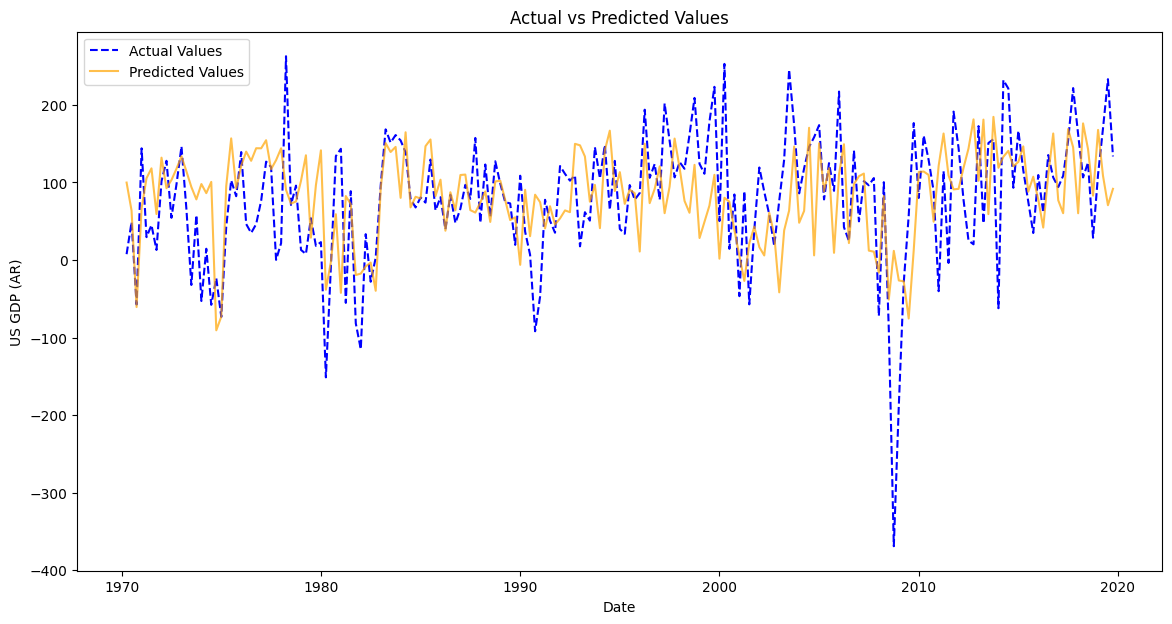

In [30]:
X = data_diff[['US unemployment', 'US 10-YEAR TREASURY BONDS YIELD', 'Non-Farm', 'US CPI',
               'US PERSONAL CURRENT TAXES (AR)', 'US CURRENT ACCOUNT BALANCE']]
y = data_diff['US GDP (AR)']
kf = KFold(n_splits=5)

mse_scores = []
mae_scores = []
r2_scores = []
adjusted_r2_scores = []
all_y_test = []
all_y_pred = []
test_dates = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    
    model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.1, max_depth=5)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    # Store actual and predicted values for plotting
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred_test)
    test_dates.extend(X_test.index)

    
    mse = mean_squared_error(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    n_obs = len(y_test)
    n_features = X_test.shape[1]
    r2_adjusted = 1 - ((1 - r2) * (n_obs - 1) / (n_obs - n_features - 1))

    
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    adjusted_r2_scores.append(r2_adjusted)


avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)


print(f"Mean Squared Error:", mse_scores)
print(f"Mean Absolute Error:", mae_scores)
print(f"R-squared:", r2_scores)
print(f"Adjusted R-squared:", adjusted_r2_scores)
print(f"Averge Mean Squared Error:", avg_mse)
print(f"Average Mean Absolute Error:", avg_mae)


# Sort the data by dates
sorted_indices = np.argsort(test_dates)
test_dates = np.array(test_dates)[sorted_indices]
all_y_test = np.array(all_y_test)[sorted_indices]
all_y_pred = np.array(all_y_pred)[sorted_indices]

# Plot actual vs predicted values with dates as the x-axis
plt.figure(figsize=(14, 7))
plt.plot(test_dates, all_y_test, label='Actual Values', color='blue', linestyle='dashed')
plt.plot(test_dates, all_y_pred, label='Predicted Values', color='orange', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('US GDP (AR)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## Gradient Boosting Regressor with Cross_validation with Time Series

Mean Squared Error: [6505.779682103345, 4924.8049309996995, 7238.122080893524, 12487.142766145727, 5713.022669323389]
Mean Absolute Error: [68.16946530568293, 58.182443314661604, 69.53019545514685, 75.05522979065532, 64.20903945991063]
R-squared: [-0.06957039721555702, -0.7328424107306062, -0.49117651739588664, 0.10982665354799159, -0.28395232945556015]
Adjusted R-squared: [-0.31639433503453174, -1.1327291208992074, -0.8352941752564758, -0.0955979648640104, -0.5802490208683817]
Average Mean Squared Error: 7373.774425893137
Average Mean Absolute Error: 67.02927466521146


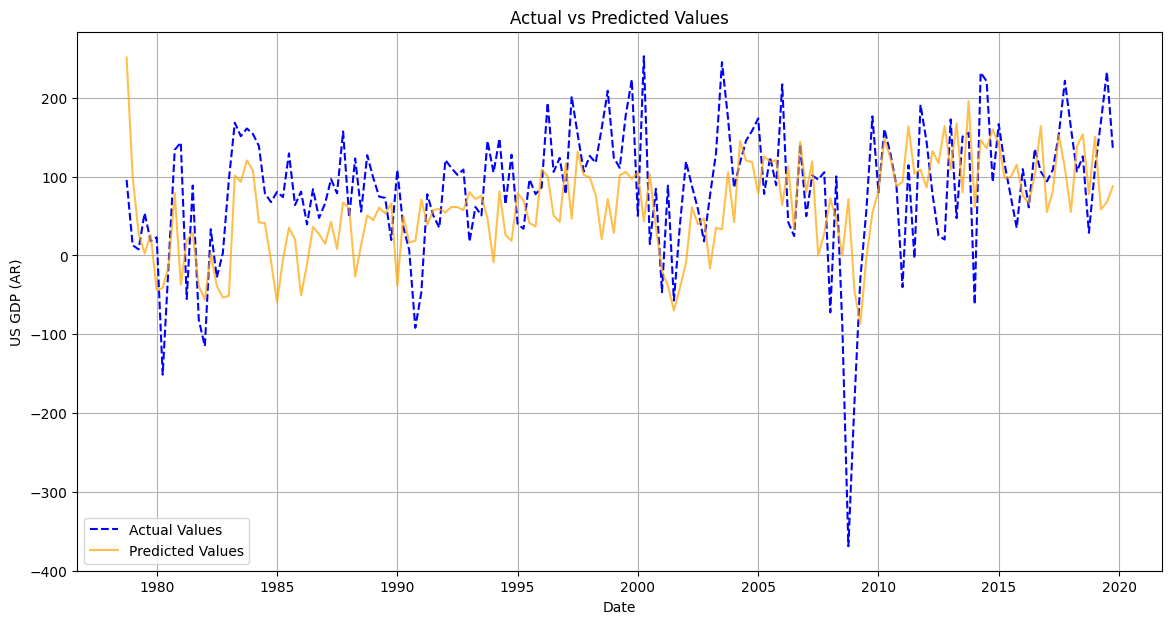

In [31]:
X = data_diff[['US unemployment', 'US 10-YEAR TREASURY BONDS YIELD', 'Non-Farm', 'US CPI',
               'US PERSONAL CURRENT TAXES (AR)', 'US CURRENT ACCOUNT BALANCE']]
y = data_diff['US GDP (AR)']
tscv = TimeSeriesSplit(n_splits=5)

# Prepare to collect metrics
mse_scores = []
mae_scores = []
r2_scores = []
adjusted_r2_scores = []

# Arrays to store actual and predicted values for plotting
all_y_test = []
all_y_pred = []
test_dates = []

# Begin cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create and fit the model
    model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.1, max_depth=5)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)

    # Store actual and predicted values for plotting
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred_test)
    test_dates.extend(X_test.index)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred_test)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    n_obs = len(y_test)
    n_features = X_test.shape[1]
    r2_adjusted = 1 - ((1 - r2) * (n_obs - 1) / (n_obs - n_features - 1))

    # Store metrics
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    adjusted_r2_scores.append(r2_adjusted)

# Calculate average metrics
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)

print(f"Mean Squared Error:", mse_scores)
print(f"Mean Absolute Error:", mae_scores)
print(f"R-squared:", r2_scores)
print(f"Adjusted R-squared:", adjusted_r2_scores)

print(f"Average Mean Squared Error:", avg_mse)
print(f"Average Mean Absolute Error:", avg_mae)

# Sort the data by dates
sorted_indices = np.argsort(test_dates)
test_dates = np.array(test_dates)[sorted_indices]
all_y_test = np.array(all_y_test)[sorted_indices]
all_y_pred = np.array(all_y_pred)[sorted_indices]

# Plot actual vs predicted values with dates as the x-axis
plt.figure(figsize=(14, 7))
plt.plot(test_dates, all_y_test, label='Actual Values', color='blue', linestyle='dashed')
plt.plot(test_dates, all_y_pred, label='Predicted Values', color='orange', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('US GDP (AR)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## **Deep Learning**

## **RNN and LSTM Model associated to Cross-Validation**

## RNN with Cross-Validation with K-Fold

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5, 30)             1110      
                                                                 
 time_distributed (TimeDistr  (None, 5, 30)            0         
 ibuted)                                                         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 30)                1830      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 2,971
Trainable params: 2,971
Non-trainable params: 0
_________________________________________________________________
None
2/2 [==============================] - 0s 4ms/step
Model: "sequential_1"
__________________________________________

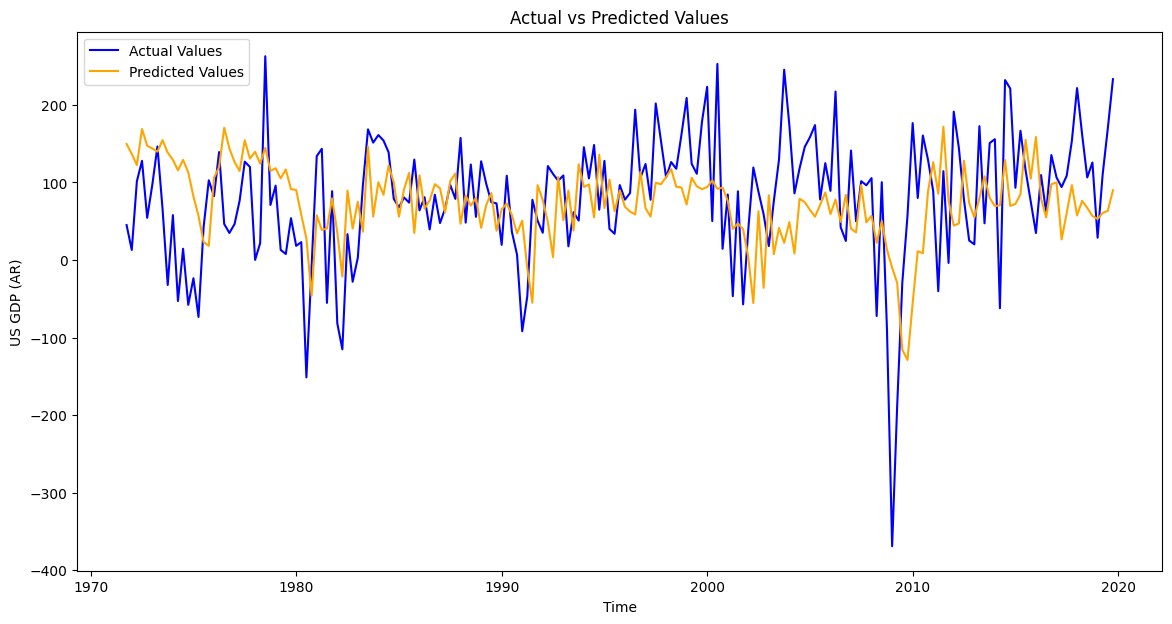

In [32]:
features = [col for col in data_diff.columns if col != 'US GDP (AR)']
target = 'US GDP (AR)'

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_diff[features + [target]])

# Function to create dataset suitable for RNN
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :-1]  # Features
        X.append(a)
        Y.append(dataset[i + look_back, -1])  # Target
    return np.array(X), np.array(Y)

# Define look-back period
look_back = 5
X, y = create_dataset(scaled_data, look_back)

# Initialize K-Fold cross-validation
kf = KFold(n_splits=5)

# Prepare to collect metrics
mse_scores = []
mae_scores = []
r2_scores = []
adjusted_r2_scores = []

# Arrays to store actual and predicted values for plotting
all_y_test_rescaled = []
all_y_pred_rescaled = []
all_test_indices = []

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Define the RNN model
    model = Sequential([
        SimpleRNN(30, input_shape=(look_back, len(features)), return_sequences=True),
        TimeDistributed(Dropout(rate=0.2)),
        SimpleRNN(30),
        Dense(1)
    ])
    print(model.summary())
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(X_train, y_train, epochs=150, batch_size=16, verbose=0) 

    # Predict on the testing data
    y_pred = model.predict(X_test)

    # Inverse transform to convert predictions back to original scale
    y_pred_rescaled = scaler.inverse_transform(np.column_stack([np.zeros((y_pred.shape[0], len(features))), y_pred]))[:, -1]
    y_test_rescaled = scaler.inverse_transform(np.column_stack([np.zeros((y_test.shape[0], len(features))), y_test]))[:, -1]

    # Store actual and predicted values for plotting
    all_y_test_rescaled.extend(y_test_rescaled)
    all_y_pred_rescaled.extend(y_pred_rescaled)
    all_test_indices.extend(test_index)

    # Calculate MSE and MAE on the original scale
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    # Calculate adjusted R2
    n = len(y_test_rescaled)
    p = len(features) + 1  # Number of predictors + intercept
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Store metrics
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    adjusted_r2_scores.append(adj_r2)

# Calculate average metrics
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)

print(features) 
print(f"Mean Squared Error:", mse_scores)
print(f"Mean Absolute Error:", mae_scores)
print(f"R-squared:", r2_scores)
print(f"Adjusted R-squared:", adjusted_r2_scores)
print(f"Average Mean Squared Error: {avg_mse:.3f}")
print(f"Average Mean Absolute Error: {avg_mae:.3f}")


# Plot actual vs predicted values with time as the x-axis
test_dates = data_diff.index[look_back + 1:][all_test_indices]

plt.figure(figsize=(14, 7))
plt.plot(test_dates, all_y_test_rescaled, label='Actual Values', color='blue')
plt.plot(test_dates, all_y_pred_rescaled, label='Predicted Values', color='orange')
plt.xlabel('Time')
plt.ylabel('US GDP (AR)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


# RNN with Cross-Validation and Time Series

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 5, 30)             1110      
                                                                 
 time_distributed_5 (TimeDis  (None, 5, 30)            0         
 tributed)                                                       
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 30)                1830      
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 2,971
Trainable params: 2,971
Non-trainable params: 0
_________________________________________________________________
None
1/1 [==============================] - 0s 474ms/step
Model: "sequential_6"
______________________________________

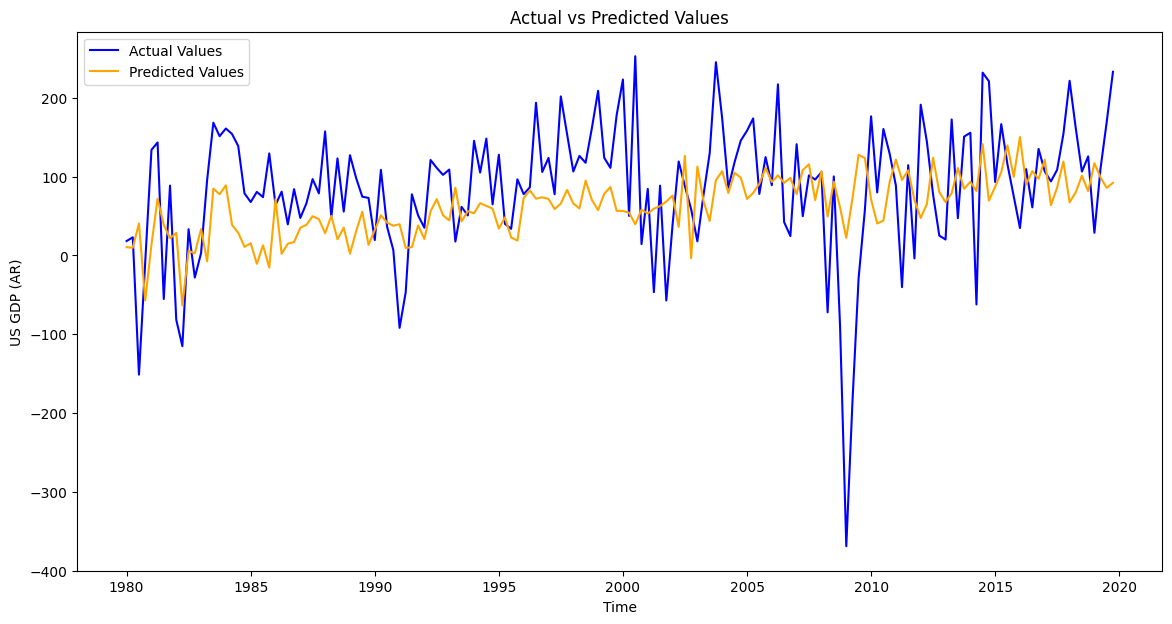

In [33]:
features = [col for col in data_diff.columns if col != 'US GDP (AR)']
target = 'US GDP (AR)'

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_diff[features + [target]])

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :-1]  # Features
        X.append(a)
        Y.append(dataset[i + look_back, -1])  # Target
    return np.array(X), np.array(Y)

look_back = 5
X, y = create_dataset(scaled_data, look_back)

tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
mae_scores = []
r2_scores = []
adjusted_r2_scores = []

all_y_test_rescaled = []
all_y_pred_rescaled = []
all_test_indices = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = Sequential([
        SimpleRNN(30, input_shape=(look_back, len(features)), return_sequences=True),
        TimeDistributed(Dropout(rate=0.2)),
        SimpleRNN(30),
        Dense(1)
    ])
    print(model.summary())
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(X_train, y_train, epochs=150, batch_size=16, verbose=0) 

    y_pred = model.predict(X_test)

    y_pred_rescaled = scaler.inverse_transform(np.column_stack([np.zeros((y_pred.shape[0], len(features))), y_pred]))[:, -1]
    y_test_rescaled = scaler.inverse_transform(np.column_stack([np.zeros((y_test.shape[0], len(features))), y_test]))[:, -1]

    all_y_test_rescaled.extend(y_test_rescaled)
    all_y_pred_rescaled.extend(y_pred_rescaled)
    all_test_indices.extend(test_index)

    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    n = len(y_test_rescaled)
    p = len(features) + 1
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    adjusted_r2_scores.append(adj_r2)

avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)


print(f"Mean Squared Error:", mse_scores)
print(f"Mean Absolute Error:", mae_scores)
print(f"R-squared:", r2_scores)
print(f"Adjusted R-squared:", adjusted_r2_scores)

print(f"Average Mean Squared Error: {avg_mse:.3f}")
print(f"Average Mean Absolute Error: {avg_mae:.3f}")


test_dates = data_diff.index[look_back + 1:][all_test_indices]

plt.figure(figsize=(14, 7))
plt.plot(test_dates, all_y_test_rescaled, label='Actual Values', color='blue')
plt.plot(test_dates, all_y_pred_rescaled, label='Predicted Values', color='orange')
plt.xlabel('Time')
plt.ylabel('US GDP (AR)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## LSTM with Cross-Validation with K-Fold

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 30)             4440      
                                                                 
 time_distributed_10 (TimeDi  (None, 5, 30)            0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 30)                7320      
                                                                 
 dense_10 (Dense)            (None, 1)                 31        
                                                                 
Total params: 11,791
Trainable params: 11,791
Non-trainable params: 0
_________________________________________________________________
None
1/1 [==============================] - 1s 728ms/step
Model: "sequential_11"
__________________________________

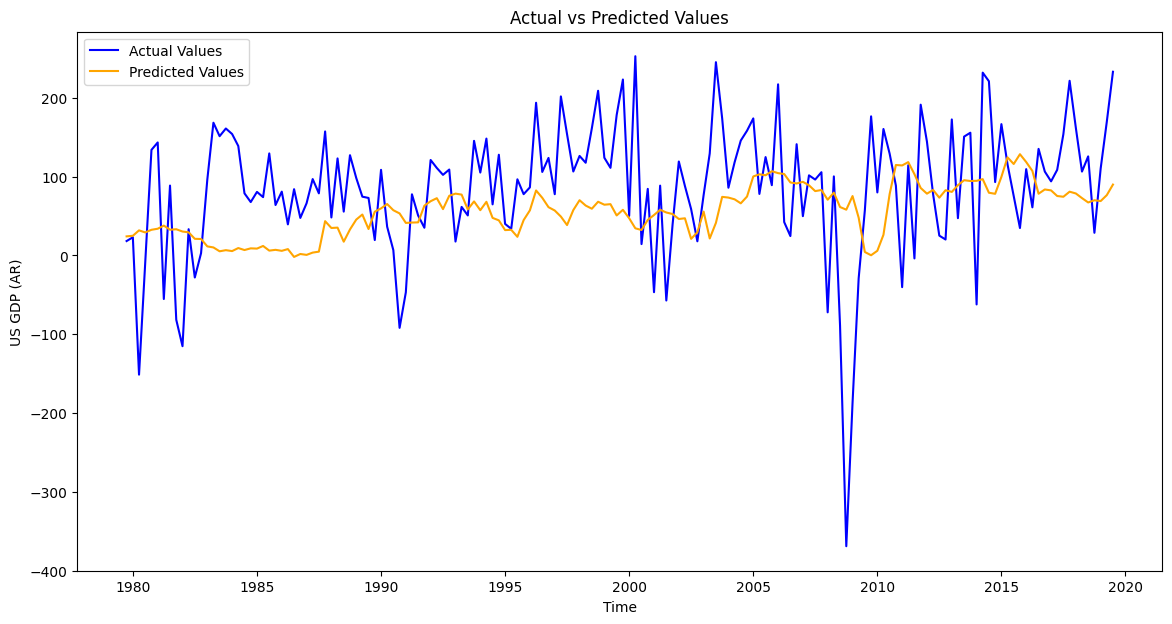

In [34]:
features = [col for col in data_diff.columns if col != 'US GDP (AR)']
target = 'US GDP (AR)'

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_diff[features + [target]])

# Function to create dataset suitable for LSTM
def create_dataset(dataset, look_back=1):
    X, Y, dates = [], [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :-1]  # Features
        X.append(a)
        Y.append(dataset[i + look_back, -1])  # Target
        dates.append(data_diff.index[i + look_back])  # Record the date
    return np.array(X), np.array(Y), dates

# Define look-back period
look_back = 5
X, y, dates = create_dataset(scaled_data, look_back)

# Initialize TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Prepare to collect metrics
mse_scores = []
mae_scores = []
r2_scores = []
adjusted_r2_scores = []

# Arrays to store actual and predicted values for plotting
all_y_test_rescaled = []
all_y_pred_rescaled = []
all_test_dates = []

# Perform TimeSeriesSplit cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    test_dates = [dates[i] for i in test_index]

    # Define the LSTM model
    model = Sequential([
        LSTM(30, input_shape=(look_back, len(features)), return_sequences=True),
        TimeDistributed(Dropout(rate=0.2)),
        LSTM(30),
        Dense(1)
    ])
    print(model.summary())
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(X_train, y_train, epochs=150, batch_size=16, verbose=0) 

    # Predict on the testing data
    y_pred = model.predict(X_test)

    # Inverse transform to convert predictions back to original scale
    y_pred_rescaled = scaler.inverse_transform(np.column_stack([np.zeros((y_pred.shape[0], len(features))), y_pred]))[:, -1]
    y_test_rescaled = scaler.inverse_transform(np.column_stack([np.zeros((y_test.shape[0], len(features))), y_test]))[:, -1]

    # Store actual and predicted values for plotting
    all_y_test_rescaled.extend(y_test_rescaled)
    all_y_pred_rescaled.extend(y_pred_rescaled)
    all_test_dates.extend(test_dates)

    # Calculate MSE and MAE on the original scale
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    # Calculate adjusted R2
    n = len(y_test_rescaled)
    p = len(features) + 1  # Number of predictors + intercept
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Store metrics
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    adjusted_r2_scores.append(adj_r2)

# Calculate average metrics
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)

print(f"Mean Squared Error:", mse_scores)
print(f"Mean Absolute Error:", mae_scores)
print(f"R-squared:", r2_scores)
print(f"Adjusted R-squared:", adjusted_r2_scores)

print(f"Average Mean Squared Error: {avg_mse:.3f}")
print(f"Average Mean Absolute Error: {avg_mae:.3f}")


# Plot actual vs predicted values with time as the x-axis
plt.figure(figsize=(14, 7))
plt.plot(all_test_dates, all_y_test_rescaled, label='Actual Values', color='blue')
plt.plot(all_test_dates, all_y_pred_rescaled, label='Predicted Values', color='orange')
plt.xlabel('Time')
plt.ylabel('US GDP (AR)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## LSTM with Cross-Validation with Time Series

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 5, 30)             4440      
                                                                 
 time_distributed_15 (TimeDi  (None, 5, 30)            0         
 stributed)                                                      
                                                                 
 lstm_11 (LSTM)              (None, 30)                7320      
                                                                 
 dense_15 (Dense)            (None, 1)                 31        
                                                                 
Total params: 11,791
Trainable params: 11,791
Non-trainable params: 0
_________________________________________________________________
None
1/1 [==============================] - 1s 1s/step
Model: "sequential_16"
_____________________________________

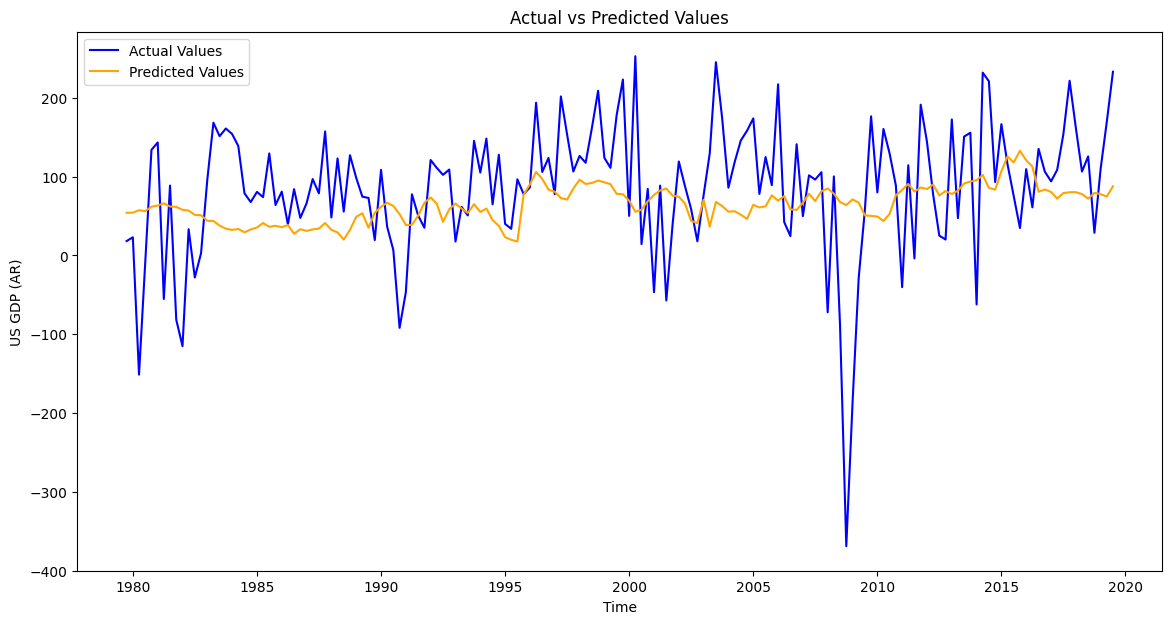

In [35]:
features = [col for col in data_diff.columns if col != 'US GDP (AR)']
target = 'US GDP (AR)'

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_diff[features + [target]])

# Function to create dataset suitable for LSTM
def create_dataset(dataset, look_back=1):
    X, Y, dates = [], [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :-1]  # Features
        X.append(a)
        Y.append(dataset[i + look_back, -1])  # Target
        dates.append(data_diff.index[i + look_back])  # Record the date
    return np.array(X), np.array(Y), dates

# Define look-back period
look_back = 5
X, y, dates = create_dataset(scaled_data, look_back)

# Initialize TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Prepare to collect metrics
mse_scores = []
mae_scores = []
r2_scores = []
adjusted_r2_scores = []

# Arrays to store actual and predicted values for plotting
all_y_test_rescaled = []
all_y_pred_rescaled = []
all_test_dates = []

# Perform TimeSeriesSplit cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    test_dates = [dates[i] for i in test_index]

    # Define the LSTM model
    model = Sequential([
        LSTM(30, input_shape=(look_back, len(features)), return_sequences=True),
        TimeDistributed(Dropout(rate=0.2)),
        LSTM(30),
        Dense(1)
    ])
    print(model.summary())
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(X_train, y_train, epochs=150, batch_size=16, verbose=0) 

    # Predict on the testing data
    y_pred = model.predict(X_test)

    # Inverse transform to convert predictions back to original scale
    y_pred_rescaled = scaler.inverse_transform(np.column_stack([np.zeros((y_pred.shape[0], len(features))), y_pred]))[:, -1]
    y_test_rescaled = scaler.inverse_transform(np.column_stack([np.zeros((y_test.shape[0], len(features))), y_test]))[:, -1]

    # Store actual and predicted values for plotting
    all_y_test_rescaled.extend(y_test_rescaled)
    all_y_pred_rescaled.extend(y_pred_rescaled)
    all_test_dates.extend(test_dates)

    # Calculate MSE and MAE on the original scale
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    # Calculate adjusted R2
    n = len(y_test_rescaled)
    p = len(features) + 1  # Number of predictors + intercept
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Store metrics
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    adjusted_r2_scores.append(adj_r2)

# Calculate average metrics
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)

print(f"Mean Squared Error:", mse_scores)
print(f"Mean Absolute Error:", mae_scores)
print(f"R-squared:", r2_scores)
print(f"Adjusted R-squared:", adjusted_r2_scores)

print(f"Average Mean Squared Error: {avg_mse:.3f}")
print(f"Average Mean Absolute Error: {avg_mae:.3f}")

# Plot actual vs predicted values with time as the x-axis
plt.figure(figsize=(14, 7))
plt.plot(all_test_dates, all_y_test_rescaled, label='Actual Values', color='blue')
plt.plot(all_test_dates, all_y_pred_rescaled, label='Predicted Values', color='orange')
plt.xlabel('Time')
plt.ylabel('US GDP (AR)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## RNN with the target variable only and Cross-Validation with K-Fold

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_20 (SimpleRNN)   (None, 5, 30)             960       
                                                                 
 time_distributed_20 (TimeDi  (None, 5, 30)            0         
 stributed)                                                      
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 30)                1830      
                                                                 
 dense_20 (Dense)            (None, 1)                 31        
                                                                 
Total params: 2,821
Trainable params: 2,821
Non-trainable params: 0
_________________________________________________________________
None
2/2 [==============================] - 0s 58ms/step
Model: "sequential_21"
_____________________________________

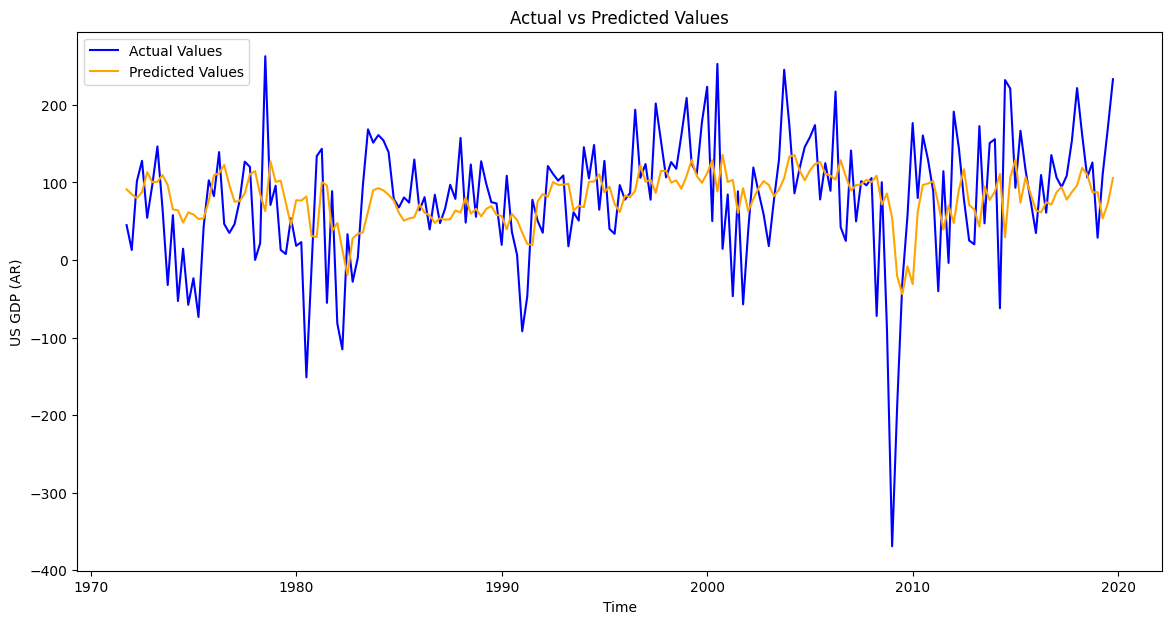

In [36]:
target = 'US GDP (AR)'
data = data_diff[[target]]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create dataset suitable for RNN
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]  # Only the target column
        X.append(a)
        Y.append(dataset[i + look_back, 0])  # Target
    return np.array(X), np.array(Y)

# Define look-back period
look_back = 5
X, y = create_dataset(scaled_data, look_back)

# Reshape X to be [samples, time steps, features] for RNN
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Initialize K-Fold cross-validation
kf = KFold(n_splits=5)

# Prepare to collect metrics
mse_scores = []
mae_scores = []
r2_scores = []
adjusted_r2_scores = []

# Arrays to store actual and predicted values for plotting
all_y_test_rescaled = []
all_y_pred_rescaled = []
all_test_indices = []

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Define the RNN model
    model = Sequential([
        SimpleRNN(30, input_shape=(look_back, 1), return_sequences=True),
        TimeDistributed(Dropout(rate=0.2)),
        SimpleRNN(30),
        Dense(1)
    ])
    print(model.summary())
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(X_train, y_train, epochs=150, batch_size=16, verbose=0) 

    # Predict on the testing data
    y_pred = model.predict(X_test)

    # Inverse transform to convert predictions back to original scale
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Store actual and predicted values for plotting
    all_y_test_rescaled.extend(y_test_rescaled[:, 0])
    all_y_pred_rescaled.extend(y_pred_rescaled[:, 0])
    all_test_indices.extend(test_index)

    # Calculate MSE and MAE on the original scale
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    # Calculate adjusted R2
    n = len(y_test_rescaled)
    p = 1  # Number of predictors
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Store metrics
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    adjusted_r2_scores.append(adj_r2)

# Calculate average metrics
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)


print(f"Mean Squared Error:", mse_scores)
print(f"Mean Absolute Error:", mae_scores)
print(f"R-squared:", r2_scores)
print(f"Adjusted R-squared:", adjusted_r2_scores)

print(f"Average Mean Squared Error: {avg_mse:.3f}")
print(f"Average Mean Absolute Error: {avg_mae:.3f}")


# Plot actual vs predicted values with time as the x-axis
test_dates = data_diff.index[look_back + 1:][all_test_indices]

plt.figure(figsize=(14, 7))
plt.plot(test_dates, all_y_test_rescaled, label='Actual Values', color='blue')
plt.plot(test_dates, all_y_pred_rescaled, label='Predicted Values', color='orange')
plt.xlabel('Time')
plt.ylabel('US GDP (AR)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## RNN with the target variable only and Cross-Validation with Time Series

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_30 (SimpleRNN)   (None, 5, 30)             960       
                                                                 
 time_distributed_25 (TimeDi  (None, 5, 30)            0         
 stributed)                                                      
                                                                 
 simple_rnn_31 (SimpleRNN)   (None, 30)                1830      
                                                                 
 dense_25 (Dense)            (None, 1)                 31        
                                                                 
Total params: 2,821
Trainable params: 2,821
Non-trainable params: 0
_________________________________________________________________
None
1/1 [==============================] - 0s 221ms/step
Model: "sequential_26"
____________________________________

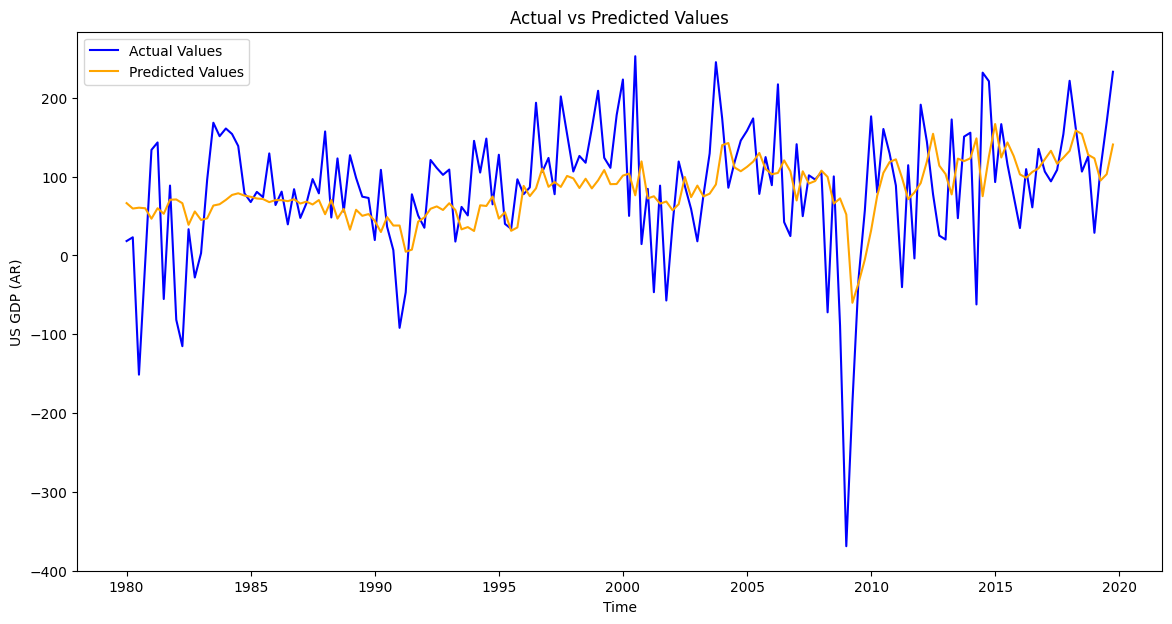

In [37]:
target = 'US GDP (AR)'
data = data_diff[[target]]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create dataset suitable for RNN
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]  # Only the target column
        X.append(a)
        Y.append(dataset[i + look_back, 0])  # Target
    return np.array(X), np.array(Y)

# Define look-back period
look_back = 5
X, y = create_dataset(scaled_data, look_back)

# Reshape X to be [samples, time steps, features] for RNN
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


tscv = TimeSeriesSplit(n_splits=5)

# Prepare to collect metrics
mse_scores = []
mae_scores = []
r2_scores = []
adjusted_r2_scores = []

# Arrays to store actual and predicted values for plotting
all_y_test_rescaled = []
all_y_pred_rescaled = []
all_test_indices = []

# Perform K-Fold cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Define the RNN model
    model = Sequential([
        SimpleRNN(30, input_shape=(look_back, 1), return_sequences=True),
        TimeDistributed(Dropout(rate=0.2)),
        SimpleRNN(30),
        Dense(1)
    ])
    print(model.summary())
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(X_train, y_train, epochs=150, batch_size=16, verbose=0) 

    # Predict on the testing data
    y_pred = model.predict(X_test)

    # Inverse transform to convert predictions back to original scale
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Store actual and predicted values for plotting
    all_y_test_rescaled.extend(y_test_rescaled[:, 0])
    all_y_pred_rescaled.extend(y_pred_rescaled[:, 0])
    all_test_indices.extend(test_index)

    # Calculate MSE and MAE on the original scale
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    # Calculate adjusted R2
    n = len(y_test_rescaled)
    p = 1  # Number of predictors
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Store metrics
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    adjusted_r2_scores.append(adj_r2)

# Calculate average metrics
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)


print(f"Mean Squared Error:", mse_scores)
print(f"Mean Absolute Error:", mae_scores)
print(f"R-squared:", r2_scores)
print(f"Adjusted R-squared:", adjusted_r2_scores)

print(f"Average Mean Squared Error: {avg_mse:.3f}")
print(f"Average Mean Absolute Error: {avg_mae:.3f}")


# Plot actual vs predicted values with time as the x-axis
test_dates = data_diff.index[look_back + 1:][all_test_indices]

plt.figure(figsize=(14, 7))
plt.plot(test_dates, all_y_test_rescaled, label='Actual Values', color='blue')
plt.plot(test_dates, all_y_pred_rescaled, label='Predicted Values', color='orange')
plt.xlabel('Time')
plt.ylabel('US GDP (AR)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## LSTM with the target variable only and Cross-Validation with K-Fold

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 5, 30)             3840      
                                                                 
 time_distributed_30 (TimeDi  (None, 5, 30)            0         
 stributed)                                                      
                                                                 
 lstm_21 (LSTM)              (None, 30)                7320      
                                                                 
 dense_30 (Dense)            (None, 1)                 31        
                                                                 
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________
None
2/2 [==============================] - 1s 5ms/step
Model: "sequential_31"
____________________________________

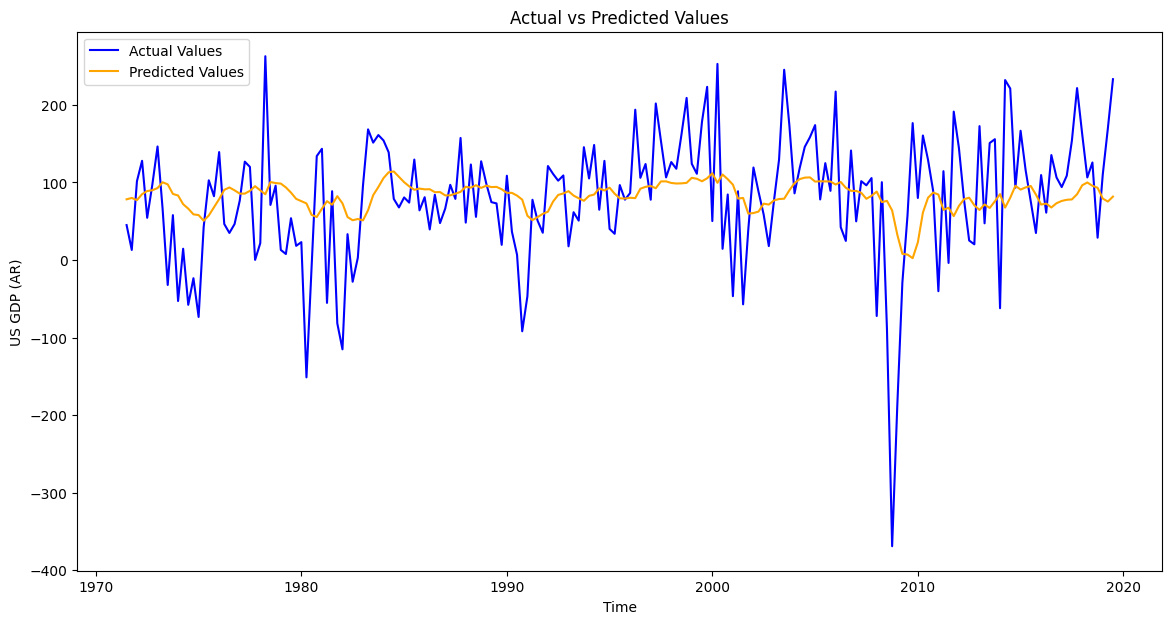

In [38]:
target = 'US GDP (AR)'
data = data_diff[[target]]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create dataset suitable for LSTM
def create_dataset(dataset, look_back=1):
    X, Y, dates = [], [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]  # Only the target column
        X.append(a)
        Y.append(dataset[i + look_back, 0])  # Target
        dates.append(data.index[i + look_back])  # Record the date
    return np.array(X), np.array(Y), dates

# Define look-back period
look_back = 5
X, y, dates = create_dataset(scaled_data, look_back)

# Reshape X to be [samples, time steps, features] for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Initialize cross-validation
kf = KFold(n_splits=5)

# Prepare to collect metrics
mse_scores = []
mae_scores = []
r2_scores = []
adjusted_r2_scores = []

# Arrays to store actual and predicted values for plotting
all_y_test_rescaled = []
all_y_pred_rescaled = []
all_test_dates = []

# Perform TimeSeriesSplit cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    test_dates = [dates[i] for i in test_index]

    # Define the LSTM model
    model = Sequential([
        LSTM(30, input_shape=(look_back, 1), return_sequences=True),
        TimeDistributed(Dropout(rate=0.2)),
        LSTM(30),
        Dense(1)
    ])
    print(model.summary())
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(X_train, y_train, epochs=150, batch_size=16, verbose=0) 

    # Predict on the testing data
    y_pred = model.predict(X_test)

    # Inverse transform to convert predictions back to original scale
    y_pred_rescaled = scaler.inverse_transform(np.column_stack([y_pred]))[:, 0]
    y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test]))[:, 0]

    # Store actual and predicted values for plotting
    all_y_test_rescaled.extend(y_test_rescaled)
    all_y_pred_rescaled.extend(y_pred_rescaled)
    all_test_dates.extend(test_dates)

    # Calculate MSE and MAE on the original scale
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    # Calculate adjusted R2
    n = len(y_test_rescaled)
    p = 1  # Number of predictors
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Store metrics
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    adjusted_r2_scores.append(adj_r2)

# Calculate average metrics
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)

print(f"Mean Squared Error:", mse_scores)
print(f"Mean Absolute Error:", mae_scores)
print(f"R-squared:", r2_scores)
print(f"Adjusted R-squared:", adjusted_r2_scores)

print(f"Average Mean Squared Error: {avg_mse:.3f}")
print(f"Average Mean Absolute Error: {avg_mae:.3f}")

# Plot actual vs predicted values with time as the x-axis
plt.figure(figsize=(14, 7))
plt.plot(all_test_dates, all_y_test_rescaled, label='Actual Values', color='blue')
plt.plot(all_test_dates, all_y_pred_rescaled, label='Predicted Values', color='orange')
plt.xlabel('Time')
plt.ylabel('US GDP (AR)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## LSTM with Cross-Validation with K-Fold

## LSTM with the target variable only and Cross-Validation with Time Series

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_40 (SimpleRNN)   (None, 5, 30)             960       
                                                                 
 time_distributed_35 (TimeDi  (None, 5, 30)            0         
 stributed)                                                      
                                                                 
 simple_rnn_41 (SimpleRNN)   (None, 30)                1830      
                                                                 
 dense_35 (Dense)            (None, 1)                 31        
                                                                 
Total params: 2,821
Trainable params: 2,821
Non-trainable params: 0
_________________________________________________________________
None
1/1 [==============================] - 0s 380ms/step
Model: "sequential_36"
____________________________________

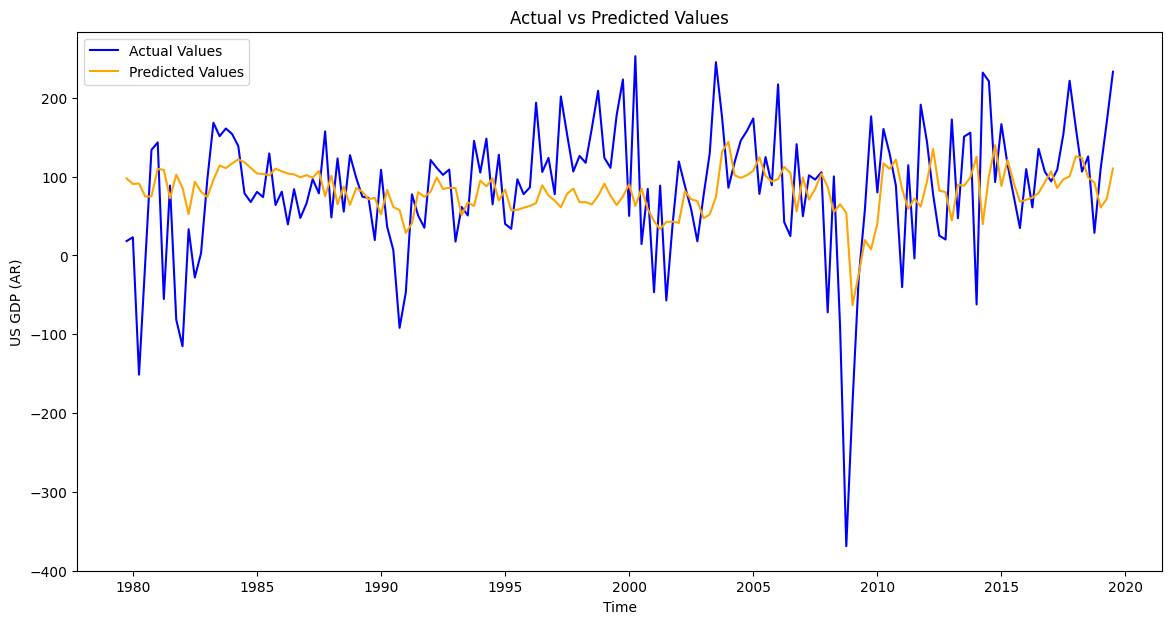

In [39]:
target = 'US GDP (AR)'
data = data_diff[[target]]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create dataset suitable for LSTM
def create_dataset(dataset, look_back=1):
    X, Y, dates = [], [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]  # Only the target column
        X.append(a)
        Y.append(dataset[i + look_back, 0])  # Target
        dates.append(data.index[i + look_back])  # Record the date
    return np.array(X), np.array(Y), dates

# Define look-back period
look_back = 5
X, y, dates = create_dataset(scaled_data, look_back)

# Reshape X to be [samples, time steps, features] for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Initialize TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Prepare to collect metrics
mse_scores = []
mae_scores = []
r2_scores = []
adjusted_r2_scores = []

# Arrays to store actual and predicted values for plotting
all_y_test_rescaled = []
all_y_pred_rescaled = []
all_test_dates = []

# Perform TimeSeriesSplit cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    test_dates = [dates[i] for i in test_index]

    # Define the LSTM model
    model = Sequential([
        SimpleRNN(30, input_shape=(look_back, 1), return_sequences=True),
        TimeDistributed(Dropout(rate=0.2)),
        SimpleRNN(30),
        Dense(1)
    ])
    print(model.summary())
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(X_train, y_train, epochs=150, batch_size=16, verbose=0) 

    # Predict on the testing data
    y_pred = model.predict(X_test)

    # Inverse transform to convert predictions back to original scale
    y_pred_rescaled = scaler.inverse_transform(np.column_stack([y_pred]))[:, 0]
    y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test]))[:, 0]

    # Store actual and predicted values for plotting
    all_y_test_rescaled.extend(y_test_rescaled)
    all_y_pred_rescaled.extend(y_pred_rescaled)
    all_test_dates.extend(test_dates)

    # Calculate MSE and MAE on the original scale
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    # Calculate adjusted R2
    n = len(y_test_rescaled)
    p = 1  # Number of predictors
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Store metrics
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    adjusted_r2_scores.append(adj_r2)

# Calculate average metrics
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)

print(f"Mean Squared Error:", mse_scores)
print(f"Mean Absolute Error:", mae_scores)
print(f"R-squared:", r2_scores)
print(f"Adjusted R-squared:", adjusted_r2_scores)

print(f"Average Mean Squared Error: {avg_mse:.3f}")
print(f"Average Mean Absolute Error: {avg_mae:.3f}")

# Plot actual vs predicted values with time as the x-axis
plt.figure(figsize=(14, 7))
plt.plot(all_test_dates, all_y_test_rescaled, label='Actual Values', color='blue')
plt.plot(all_test_dates, all_y_pred_rescaled, label='Predicted Values', color='orange')
plt.xlabel('Time')
plt.ylabel('US GDP (AR)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()